In [4]:
import sys
sys.path.insert(0,'/Users/jennytrieu/Desktop') # add code directory to path
#import lddmm
import torch_lddmm
# import numpy
import numpy as np
# import nibabel for i/o
import nibabel as nib
# import matplotlib for display
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk

**SimpleITK's procedural API provides three methods for performing resampling, with the difference being the way you specify the resampling grid:**

1. Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)

2. Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)

3. Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)

Below we use the third resampling method. 

***The goal is to make the target file (the SMI file) the same as the MRI file*** 

(0.004000000189989805, 0.004000000189989805, 1.0)
(220, 116, 14)
[98.23226112 59.23475875  6.57543992] target
[392.27772958 198.87809045  23.36704865] mri


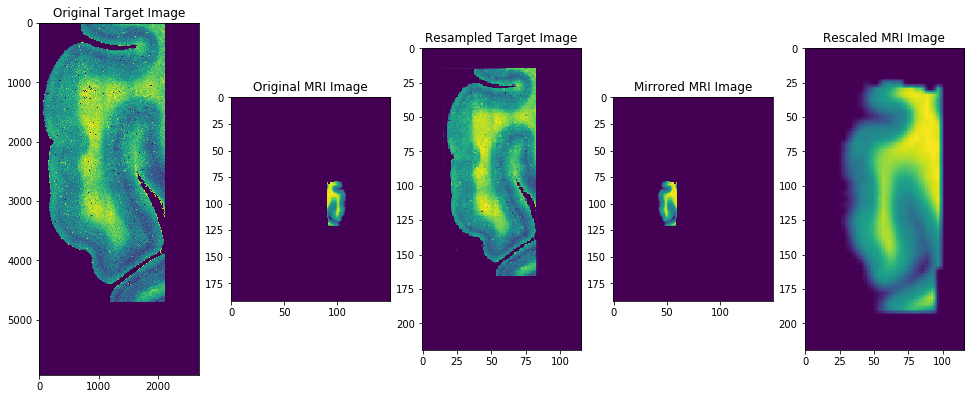

In [20]:
# load mouse brain histology and mri images
target_file_name = '/Users/jennytrieu/Desktop/Lab/Deafcats_Images/WK0145_SMI_v5_reversed.img'
mri_file_name = '/Users/jennytrieu/Desktop/Lab/Deafcats_Images/WK0145_20191120.img'

# resample target file to make it the same size as the mri file
mri_sitk = sitk.ReadImage(mri_file_name)    
target_sitk = sitk.ReadImage(target_file_name)

# removing the 4th dimension from the target file
target_data = sitk.GetArrayFromImage(target_sitk)
target_data = np.squeeze(target_data)
target_3D = sitk.GetImageFromArray(target_data)
target_3D.SetSpacing([target_sitk.GetSpacing()[0],target_sitk.GetSpacing()[1],target_sitk.GetSpacing()[3]])

# save the new 3D target image
sitk.WriteImage(target_3D,'/Users/jennytrieu/Desktop/Lab/Deafcats_Images/WK0145_3D_SMI_v5_reversed.img')

# update target file name
target_file_name = '/Users/jennytrieu/Desktop/Lab/Deafcats_Images/WK0145_3D_SMI_v5_reversed.img'

# read in new target that's been reduced from 4->3 dimensions
target_sitk = sitk.ReadImage(target_file_name)
print(target_sitk.GetSpacing())

# resample the target image
#output_size = [mri_sitk.GetSize()[0],mri_sitk.GetSize()[1],target_3D.GetSize()[2]]
output_spacing = [mri_sitk.GetSpacing()[0]/4,mri_sitk.GetSpacing()[1]/4,target_3D.GetSpacing()[2]]
output_size = [int(np.round(target_3D.GetSize()[0]*target_3D.GetSpacing()[0]/output_spacing[0])),
               int(np.round(target_3D.GetSize()[1]*target_3D.GetSpacing()[1]/output_spacing[1])),
               target_3D.GetSize()[2]]
target_resample = sitk.Resample(sitk.SmoothingRecursiveGaussian(target_3D,
                                                                target_3D.GetSpacing()[0]*2),
                                                                output_size,
                                                                sitk.AffineTransform(3),
                                                                sitk.sitkLinear,
                                                                (0,0,0),
                                                                output_spacing,
                                                                (1,0,0,0,1,0,0,0,1), 0.0)

# pad the resampled target
target_resample_np = np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))
pad_amount = [15,15,4]
target_padded_np = np.zeros((target_resample_np.shape[0]+pad_amount[0]*2,target_resample_np.shape[1]+pad_amount[1]*2,target_resample_np.shape[2]+pad_amount[2]*2))
target_padded_np[pad_amount[0]:-pad_amount[0],pad_amount[1]:-pad_amount[1],pad_amount[2]:-pad_amount[2]] = target_resample_np

target_resample = sitk.GetImageFromArray(np.transpose(target_padded_np,(2,1,0)))
target_resample.SetSpacing(output_spacing)

print(target_resample.GetSize())

# save the new 3D target resampled image
sitk.WriteImage(target_resample,'/Users/jennytrieu/Desktop/Lab/Deafcats_Images/WK0145_3D_SMI_resampled.img')

# update target file name to new 3D target resampled image
target_file_name = '/Users/jennytrieu/Desktop/Lab/Deafcats_Images/WK0145_3D_SMI_resampled.img'

# load mri and target data into numpy arrays
target_image_struct = nib.load(target_file_name)
mri_image_struct = nib.load(mri_file_name)
target_image = np.squeeze(target_image_struct.get_data()).astype(np.float32)
mri_image = np.squeeze(mri_image_struct.get_data()).astype(np.float32)

mri_image_mirrored = mri_image[:,mri_image.shape[1]:None:-1,:] # mirror mri in y dimension
mri_image_mirrored_sitk = sitk.GetImageFromArray(np.transpose(mri_image_mirrored,(2,1,0)))
mri_image_mirrored_sitk.SetSpacing(mri_sitk.GetSpacing())
mri_output_size = [int(np.round(mri_sitk.GetSize()[0]*mri_sitk.GetSpacing()[0]/output_spacing[0])),int(np.round(mri_sitk.GetSize()[1]*mri_sitk.GetSpacing()[1]/output_spacing[1])),int(np.round(mri_sitk.GetSize()[2]*mri_sitk.GetSpacing()[2]/output_spacing[2]))]
mri_resample = sitk.Resample(mri_image_mirrored_sitk, mri_output_size, sitk.AffineTransform(3), sitk.sitkLinear,
                             (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

target_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)))),axis=1)
mri_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)))),axis=1)
print(target_center_of_mass, 'target')
print(mri_center_of_mass,'mri')

# plot translated, resampled target image
translation = sitk.TranslationTransform(3)
translation.SetOffset((-(target_center_of_mass[0]-mri_center_of_mass[0])*mri_resample.GetSpacing()[0],
                       -(target_center_of_mass[1]-mri_center_of_mass[1])*mri_resample.GetSpacing()[1],
                       -(target_center_of_mass[2]-mri_center_of_mass[2])*mri_resample.GetSpacing()[2]))
mri_transform = sitk.Resample(mri_resample, target_resample.GetSize(), translation, sitk.sitkLinear,
                                 (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()

# plot original target image
plt.subplot(1,6,1)
plt.title('Original Target Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(target_3D),(2,1,0))[:,:,1])

# plot original mri image
plt.subplot(1,6,2)
plt.imshow(mri_image[:,:,36])
plt.title('Original MRI Image')

# plot resampled target image
plt.subplot(1,6,3)
plt.title('Resampled Target Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))[:,:,5])

# plot mirrored mri image
plt.subplot(1,6,4)
plt.imshow(np.transpose(sitk.GetArrayFromImage(mri_image_mirrored_sitk),(2,1,0))[:,:,36])
plt.title('Mirrored MRI Image')

plt.subplot(1,6,5)
plt.imshow(np.transpose(sitk.GetArrayFromImage(mri_transform),(2,1,0))[:,:,1])
plt.title('Rescaled MRI Image')

sitk.WriteImage(target_resample,'/Users/jennytrieu/Desktop/Lab/Deafcats_Images/target_resample.img')
sitk.WriteImage(mri_transform,'/Users/jennytrieu/Desktop/Lab/Deafcats_Images/mri_transform.img')

## Resample the target and rigidly align the MRI

In [21]:
# # specify all the image sizes
# mripadsize = [max(target_image.shape[0],mri_image.shape[0]),
#               max(int(np.round(target_image.shape[1]/2.0)),mri_image.shape[1]),
#               max(target_image.shape[2],mri_image.shape[2])]
# print(mripadsize)
# orignisslsize = target_image.shape
# origmrisize = mri_image.shape
# origtemplatesize = template_image.shape
# templatepadsize = [max(target_image.shape[0],template_image.shape[0]),
#                    max(int(np.round(target_image.shape[1]/2.0)),template_image.shape[1]),
#                    max(target_imaprint(target_image.shape)
# ge.shape[2],template_image.shape[2])]
# print(templatepadsize)

SyntaxError: invalid syntax (<ipython-input-21-b96563612145>, line 12)

In [50]:
# target_sitk = sitk.GetImageFromArray(np.transpose(target_image,(2,1,0)))
# target_sitk.SetSpacing([0.08,0.04,0.08])

# target_sitk_resample = sitk.Resample(target_sitk,
#                                      mripadsize,
#                                      sitk.AffineTransform(3),
#                                      sitk.sitkLinear,
#                                      (0,0,0),
#                                      [0.08,0.08,0.08],
#                                      (1,0,0,0,1,0,0,0,1)
#                                      ,0.0)
# print(target_sitk_resample.GetSize())
# target_resample = np.transpose(sitk.GetArrayFromImage(target_sitk_resample),(2,1,0))
# print(target_resample.shape)

# mri_sitk = sitk.ReadImage(mri_file_name)
# print(mri_sitk.GetSize())
# mri_sitk_resample = sitk.Resample(mri_sitk,
#                                   target_resample.shape,
#                                   sitk.AffineTransform(3),
#                                   sitk.sitkLinear,
#                                   (0,0,0),
#                                   [0.08,0.08,0.08],
#                                   (1,0,0,0,1,0,0,0,1),
#                                   0.0)
# print(mri_sitk_resample.GetSize())
# mri_resample = np.transpose(sitk.GetArrayFromImage(mri_sitk_resample),(2,1,0))
# print(mri_resample.shape)

(348, 450, 345)
(348, 450, 345)
(345, 450, 345)
(348, 450, 345)
(348, 450, 345)


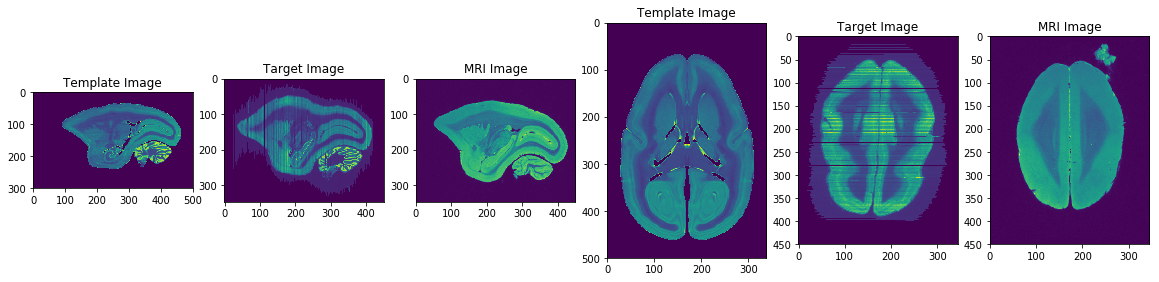

In [51]:
# plt.figure()
# plt.subplot(1,6,1)
# plt.imshow(template_image[:,:,100])
# plt.title('Template Image')
# plt.subplot(1,6,2)
# plt.imshow(target_resample[:,:,100])
# plt.title('Target Image')
# plt.subplot(1,6,3)
# plt.imshow(mri_resample[:,:,100])
# plt.title('MRI Image')
# plt.subplot(1,6,4)
# plt.imshow(template_image[96,:,:])
# plt.title('Template Image')
# plt.subplot(1,6,5)
# plt.imshow(target_resample[96,:,:])
# plt.title('Target Image')
# plt.subplot(1,6,6)
# plt.imshow(mri_resample[96,:,:])
# plt.title('MRI Image')
# plt.show()

## Start with alignment to self

In [25]:
# need to change these to numpy arrays
mri_transform_arr = np.transpose(sitk.GetArrayFromImage(mri_transform),[2,1,0])*255.0
target_resample_arr = np.transpose(sitk.GetArrayFromImage(target_resample),[2,1,0])

lddmm = torch_lddmm.LDDMM(template=[mri_transform_arr],target=[target_resample_arr],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                          dx=output_spacing,cc=0,gpu_number = None,checkaffinestep=1)
lddmm._checkParameters()
lddmm._load(lddmm.params['template'],lddmm.params['target'],lddmm.params['costmask'])
lddmm.initializeVariables()
lddmm.initializeKernels()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 1 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = None (index of

In [26]:
# Grab the indices of the missing slices
missingslices = []
for i in range(target_resample_arr.shape[2]):
    if np.unique(target_image[:,:,i]).shape[0] < 3:
        missingslices.append(i)
print(missingslices)


#origJ = lddmm.J[0].clone()
epsilonxy = 4e-7
epsilontheta=2e-7
a = None
b = None
theta = None
niter = 500

a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_resample_arr).type(torch.FloatTensor),torch.tensor(target_resample_arr).type(torch.FloatTensor),niter=niter,dim=2,norm=0,missingslices=missingslices,sigma_atlas=99999999999.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_resample_arr.shape),dx=output_spacing,epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4, sigma_target_radius=1, sigma_atlas_radius=1)
#lddmm.setParams('a',4)
outtarget = lddmm.applySA(torch.tensor(target_resample_arr).type(torch.FloatTensor), a, b, theta, dim=2,nx=list(target_resample_arr.shape),dx=output_spacing).numpy().astype(np.float32)
    

[0, 1, 2, 3, 10, 11, 12, 13]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


iter: 1, E= 2119.716, Eim_t= 2119.716, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 2118.647, Eim_t= 2118.647, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 3, E= 2115.562, Eim_t= 2115.562, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 4, E= 2114.664, Eim_t= 2114.664, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 5, E= 2111.440, Eim_t= 2111.440, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 6, E= 2110.529, Eim_t= 2110.529, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 7, E= 2107.362, Eim_t= 2107.362, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 8, E= 2106.433, Eim_t= 2106.433, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 9, E= 2103.340, Eim_t= 2103.34

iter: 71, E= 1976.705, Eim_t= 1976.699, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0061, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 72, E= 1974.351, Eim_t= 1974.345, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0061, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 73, E= 1972.098, Eim_t= 1972.092, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0066, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 74, E= 1969.687, Eim_t= 1969.680, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0066, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 75, E= 1967.509, Eim_t= 1967.501, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0071, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 76, E= 1965.055, Eim_t= 1965.048, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0071, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 77, E= 1962.984, Eim_t= 1962.976, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0076, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 78, E= 1960.499, Eim_t= 1960.491, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0076, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 79, E= 195

iter: 140, E= 1811.934, Eim_t= 1811.914, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0194, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 141, E= 1811.568, Eim_t= 1811.548, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0192, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 142, E= 1805.397, Eim_t= 1805.377, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0192, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 143, E= 1804.988, Eim_t= 1804.969, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0191, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 144, E= 1798.583, Eim_t= 1798.564, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0191, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 145, E= 1798.171, Eim_t= 1798.151, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0189, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 146, E= 1791.549, Eim_t= 1791.529, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0189, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 147, E= 1791.163, Eim_t= 1791.144, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0187, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 14

iter: 207, E= 1477.048, Eim_t= 1477.032, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0121, ep_xy= 0.0001, ep_t= 0.0000, time= 0.06.
iter: 208, E= 1469.754, Eim_t= 1469.738, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0121, ep_xy= 0.0001, ep_t= 0.0000, time= 0.06.
iter: 209, E= 1469.596, Eim_t= 1469.580, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0119, ep_xy= 0.0001, ep_t= 0.0000, time= 0.06.
iter: 210, E= 1462.686, Eim_t= 1462.670, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0119, ep_xy= 0.0001, ep_t= 0.0000, time= 0.05.
iter: 211, E= 1461.542, Eim_t= 1461.526, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0117, ep_xy= 0.0001, ep_t= 0.0000, time= 0.06.
iter: 212, E= 1455.179, Eim_t= 1455.163, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0117, ep_xy= 0.0001, ep_t= 0.0000, time= 0.05.
iter: 213, E= 1454.223, Eim_t= 1454.207, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0116, ep_xy= 0.0001, ep_t= 0.0000, time= 0.06.
iter: 214, E= 1448.282, Eim_t= 1448.266, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0116, ep_xy= 0.0001, ep_t= 0.0000, time= 0.05.
iter: 21

iter: 276, E= 1340.881, Eim_t= 1340.864, Eim_a= 0.000, ER_xy= 0.009, ER_t= 0.0074, ep_xy= 0.0004, ep_t= 0.0000, time= 0.05.
iter: 277, E= 1340.875, Eim_t= 1340.859, Eim_a= 0.000, ER_xy= 0.009, ER_t= 0.0072, ep_xy= 0.0004, ep_t= 0.0000, time= 0.05.
iter: 278, E= 1338.157, Eim_t= 1338.140, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0072, ep_xy= 0.0004, ep_t= 0.0000, time= 0.05.
iter: 279, E= 1338.122, Eim_t= 1338.105, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0070, ep_xy= 0.0004, ep_t= 0.0000, time= 0.06.
iter: 280, E= 1335.787, Eim_t= 1335.771, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0070, ep_xy= 0.0004, ep_t= 0.0000, time= 0.05.
iter: 281, E= 1335.735, Eim_t= 1335.718, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0068, ep_xy= 0.0004, ep_t= 0.0000, time= 0.06.
iter: 282, E= 1333.611, Eim_t= 1333.594, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0068, ep_xy= 0.0004, ep_t= 0.0000, time= 0.05.
iter: 283, E= 1333.615, Eim_t= 1333.598, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0066, ep_xy= 0.0004, ep_t= 0.0000, time= 0.06.
iter: 28

iter: 344, E= 1319.055, Eim_t= 1319.038, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0014, ep_t= 0.0000, time= 0.05.
iter: 345, E= 1319.056, Eim_t= 1319.039, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0014, ep_t= 0.0000, time= 0.06.
iter: 346, E= 1319.032, Eim_t= 1319.015, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0014, ep_t= 0.0000, time= 0.05.
iter: 347, E= 1319.032, Eim_t= 1319.015, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0014, ep_t= 0.0000, time= 0.06.
iter: 348, E= 1318.992, Eim_t= 1318.975, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0015, ep_t= 0.0000, time= 0.05.
iter: 349, E= 1318.992, Eim_t= 1318.975, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0015, ep_t= 0.0000, time= 0.05.
iter: 350, E= 1318.936, Eim_t= 1318.919, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0015, ep_t= 0.0000, time= 0.05.
iter: 351, E= 1318.936, Eim_t= 1318.919, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0015, ep_t= 0.0000, time= 0.05.
iter: 35

iter: 413, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 414, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 415, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 416, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 417, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 418, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 419, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 420, E= 1318.588, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 42

iter: 483, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 484, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 485, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 486, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 487, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 488, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 489, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.05.
iter: 490, E= 1318.589, Eim_t= 1318.571, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 49

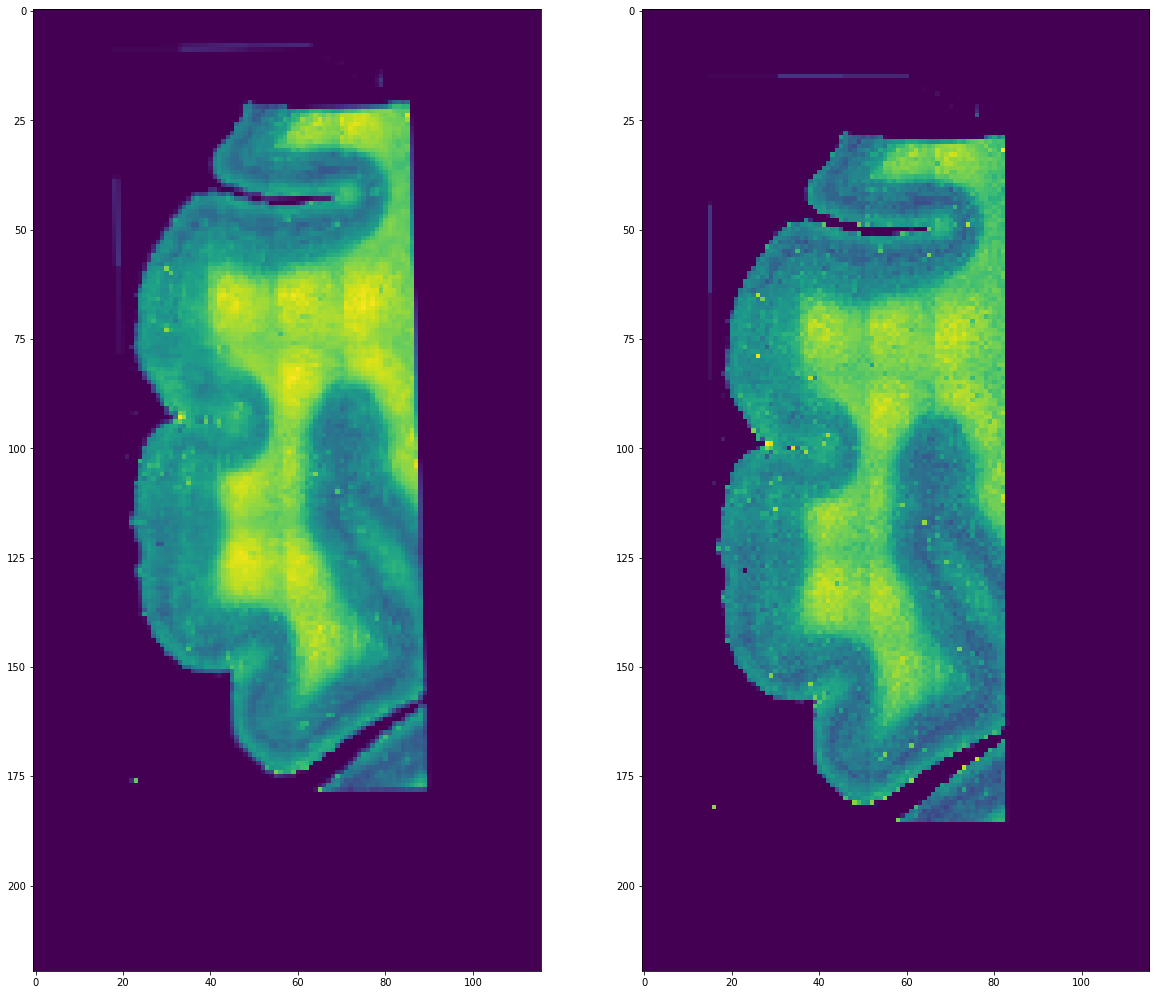

In [27]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(outtarget[:,:,6])
plt.subplot(1,2,2)
plt.imshow(target_resample_arr[:,:,6])
plt.show()

In [28]:
# check image
outimg = nib.AnalyzeImage(outtarget,None)
outimg.header['pixdim'][1:4] = output_spacing
nib.save(outimg,'/Users/jennytrieu/Desktop/Lab/Deafcats_Images/target_resectioned.img')

## Start with rigid alignment

In [89]:
# need to change these to numpy arrays
mri_transform_arr = np.transpose(sitk.GetArrayFromImage(mri_transform),[2,1,0])*255.0
target_resample_arr = np.transpose(sitk.GetArrayFromImage(target_resample),[2,1,0])

print(np.max(mri_transform_arr))
print(np.max(outtarget))
print(np.min(mri_transform_arr))
print(np.min(outtarget))

lddmm = torch_lddmm.LDDMM(template=[mri_transform_arr],target=[outtarget],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                          dx=output_spacing,cc=0,gpu_number = None,checkaffinestep=1)

210.1531
198.91019
0.0
-0.14397334

Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 1 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
> 

In [31]:
%%time
lddmm.setParams('niter',500)
# translation
lddmm.setParams('epsilonL',1e-99)
lddmm.setParams('epsilonT',2e-9)
lddmm.run()
# translation + rotation
lddmm.setParams('epsilonL',1e-9)
lddmm.setParams('epsilonT',2e-9)
lddmm.run()
# affine
lddmm.setParams('do_affine',1)
lddmm.setParams('epsilonL',1e-9)
lddmm.setParams('epsilonT',2e-9)

Parameter 'niter' changed to '500'.
Parameter 'epsilonL' changed to '1e-99'.
Parameter 'epsilonT' changed to '2e-09'.
iter: 0, E = 15169.4883, ER = 0.0000, EM = 15169.4883, epd = 0.005000.
iter: 1, E= 15169.488, ER= 0.000, EM= 15169.488, epd= 0.005, del_Ev= 0.0000, del_El= 0.0000, del_Et= 0.0000, time= 0.98s.
iter: 2, E= 15169.488, ER= 0.000, EM= 15169.488, epd= 0.005, del_Ev= 0.0000, del_El= 0.0000, del_Et= 0.0000, time= 0.89s.
iter: 3, E= 15169.488, ER= 0.000, EM= 15169.488, epd= 0.005, del_Ev= 0.0000, del_El= 0.0000, del_Et= 0.0000, time= 0.91s.
iter: 4, E= 15169.488, ER= 0.000, EM= 15169.488, epd= 0.005, del_Ev= 0.0000, del_El= 0.0000, del_Et= 0.0000, time= 0.92s.
iter: 5, E= 15169.488, ER= 0.000, EM= 15169.488, epd= 0.005, del_Ev= 0.0000, del_El= 0.0000, del_Et= 0.0000, time= 0.92s.
iter: 6, E= 15169.488, ER= 0.000, EM= 15169.488, epd= 0.005, del_Ev= 0.0000, del_El= 0.0000, del_Et= 0.0000, time= 0.93s.
iter: 7, E= 15169.488, ER= 0.000, EM= 15169.488, epd= 0.005, del_Ev= 0.0000, de

/Users/jennytrieu/Desktop/torch_lddmm.py:2210: RuntimeWarning: invalid value encountered in multiply
  e = torch.tensor(scipy.linalg.expm(-e * gradA_cpu_numpy)).type(self.params['dtype']).to(device=self.params['cuda'])


ValueError: cannot convert float NaN to integer

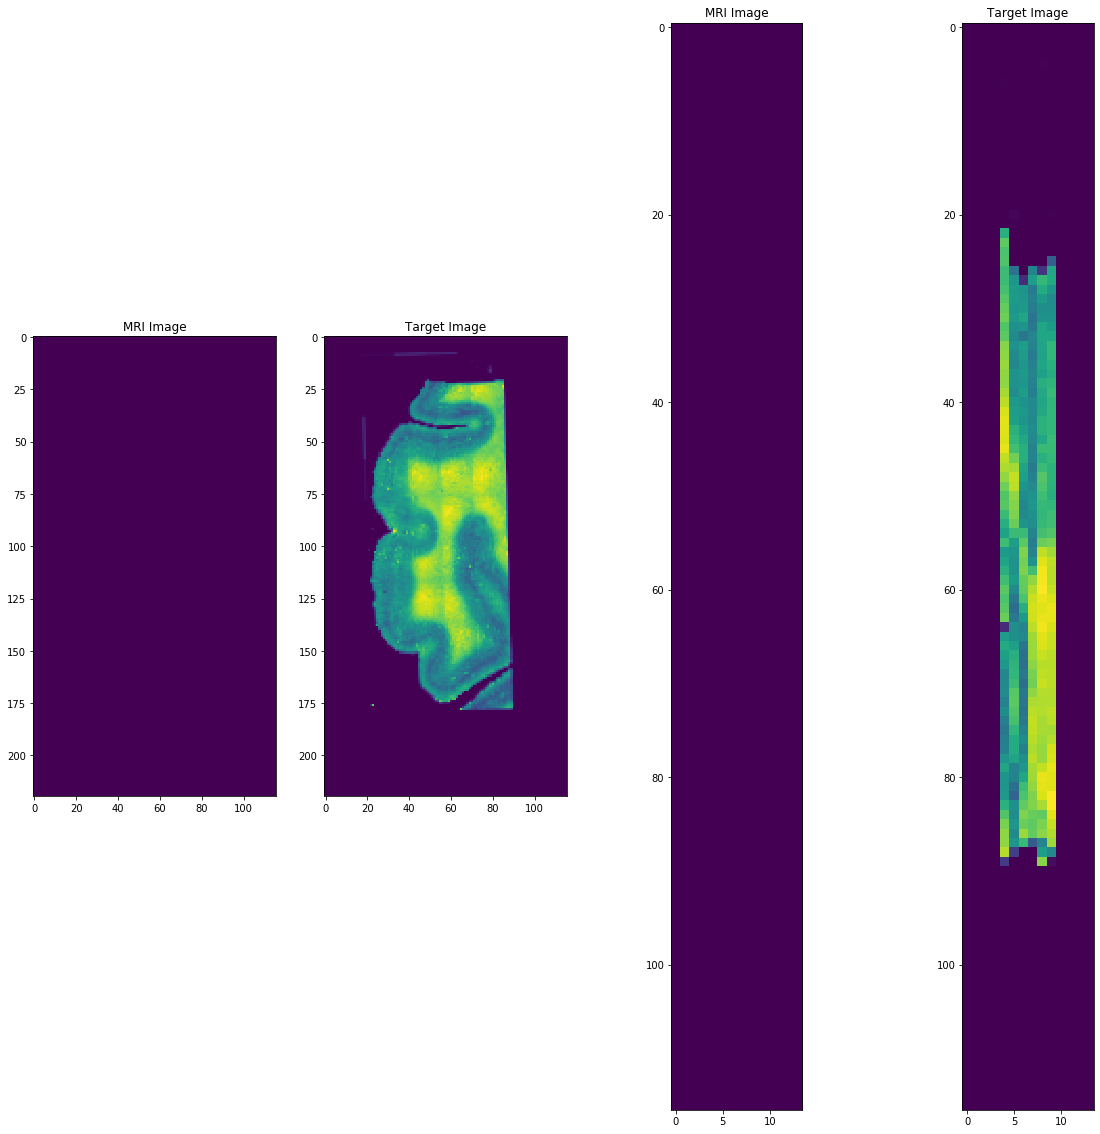

In [88]:
# apply the contrast adjustment to the MRI
#mri_adjusted = (mri_transform_arr - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()

deformed_mri = (lddmm.applyThisTransform(mri_transform_arr))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,4,1)
plt.imshow(deformed_mri[:,:,6])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget[:,:,6])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(deformed_mri[96,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget[96,:,:])
plt.title('Target Image')
plt.show()

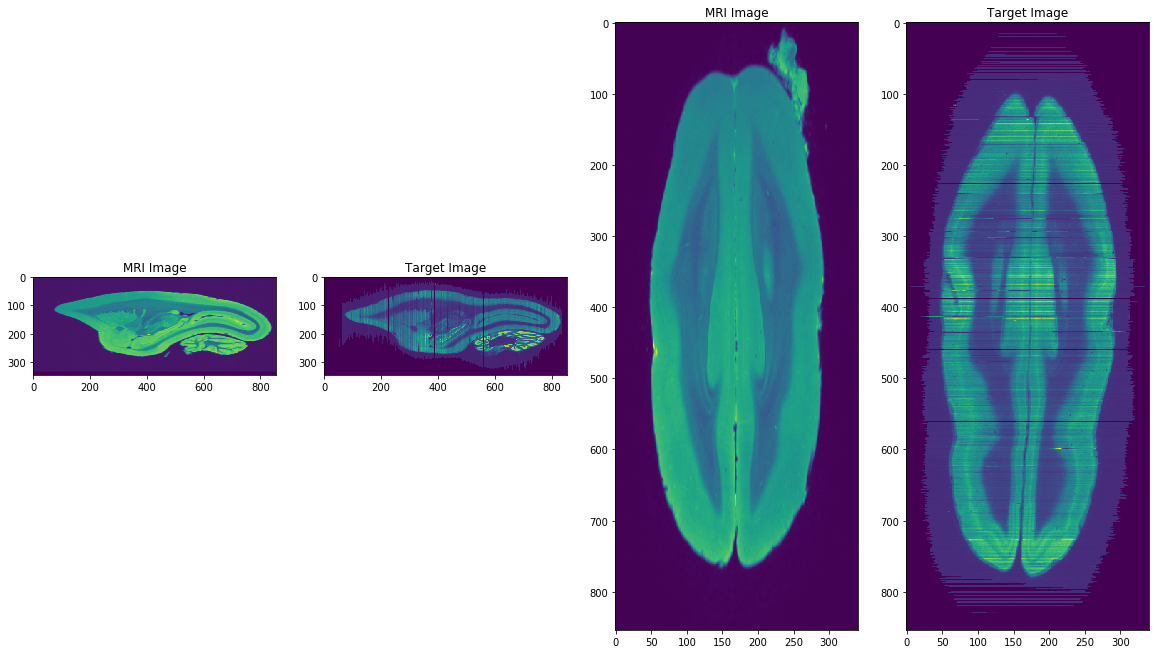

In [58]:
# resample mri back to original target size
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_resample - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()

deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

mri_sitk = sitk.GetImageFromArray(np.transpose(deformed_mri,(2,1,0)))
mri_sitk.SetSpacing((0.08,0.08,0.08))
mri_sitk_upsampled = sitk.Resample(mri_sitk,
                                   orignisslsize,
                                   sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
mri_upsampled = np.transpose(sitk.GetArrayFromImage(mri_sitk_upsampled),(2,1,0))
plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_upsampled[:,:,100])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(target_image[:,:,100])


plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_upsampled[96,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(target_image[96,:,:])
plt.title('Target Image')
plt.show()

In [59]:
outmri = nib.AnalyzeImage(mri_upsampled,None)
outmri.header['pixdim'][1:4] = [0.08,0.04,0.08]
nib.save(outmri, '/cis/home/jtrieu/Documents/mri_rigid_upsampled.img')

## Do slice alignment

In [60]:
directoryname = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/'

# Grab the indices of the missing slices
missingslices = []
for i in range(target_image.shape[1]):
    if np.unique(target_image[:,i,:]).shape[0] < 3:
        missingslices.append(i)
print(missingslices)


print(torch.tensor(target_image).type(torch.FloatTensor).cuda().shape)
print(torch.tensor(mri_upsampled).type(torch.FloatTensor).cuda().shape)
#origJ = lddmm.J[0].clone()
epsilonxy = 4e-8
epsilontheta=2e-8
a = None
b = None
theta = None

for i in range(1,8):
    if i == 1:
        niter = 600
    elif i < 3:
        niter = 100
    elif i == 7:
        niter = 800
    else:
        #epsilonxy = 2e-10
        #epsilontheta=1e-10
        niter = 200
    
    #a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(origJ,lddmm.It[0][-1],niter=niter,dim=1,epsilonxy=epsilonxy, epsilontheta=epsilontheta,norm=0,missingslices=missingslices,sigma_atlas=0.75,sigma_target=10.0,a=a,b=b,theta=theta,min_sigma_atlas=1.0)
    a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).cuda(),torch.tensor(mri_upsampled).type(torch.FloatTensor).cuda(),niter=niter,dim=1,norm=0,missingslices=missingslices,sigma_atlas=4.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=[0.08,0.04,0.08],epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4)
    #lddmm.setParams('a',4)
    outtarget = torch.transpose(lddmm.applySA(torch.tensor(target_image).type(torch.FloatTensor).cuda(), a, b, theta, dim=1,nx=list(target_image.shape),dx=[0.08,0.04,0.08]),2,1).cpu().numpy().astype(np.float32)
    lddmm.setParams('energy_fraction_from',len(lddmm.EAll)-1)
    
    # resample the target image
    #outtarget_ds = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(np.transpose(outtarget,(2,1,0))), [outtarget.shape[0],int(np.round(outtarget.shape[1]/2.0)), outtarget.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
    outtarget_np = sitk.GetImageFromArray(np.transpose(outtarget,(2,1,0)))
    outtarget_np.SetSpacing((0.08,0.04,0.08))
    outtarget_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(outtarget_np, deformed_mri.shape, sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))
    
    #lddmm.J[0] = torch.transpose(outtarget,2,1)
    lddmm.J[0] = torch.tensor(outtarget_ds).type(torch.FloatTensor).cuda()
    # reset beta
    if i > 1:
        lddmm.setParams('epsilonL',lddmm.GDBetaAffineR*lddmm.params['epsilonL']*4) # reduce step size, here we set it to the current size
    
    lddmm.setParams('epsilonT',lddmm.GDBetaAffineT*lddmm.params['epsilonT']*4) # reduce step size, here we set it to the current size
    #lddmm.GDBeta = torch.tensor(1.0).type(lddmm.params['dtype']).to(device=lddmm.params['cuda'])
    #lddmm.GDBetaAffineR = float(1.0)
    #lddmm.GDBetaAffineT = float(1.0)
    lddmm.setParams('niter',40)
    lddmm.run()
    
    # resample the mri image
    deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()
    mri_sitk = sitk.GetImageFromArray(np.transpose(deformed_mri,(2,1,0)))
    mri_sitk.SetSpacing((0.08,0.08,0.08))
    mri_sitk_upsampled = sitk.Resample(mri_sitk,orignisslsize,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
    mri_upsampled = np.transpose(sitk.GetArrayFromImage(mri_sitk_upsampled),(2,1,0))
    
    ##save
    #outimg = nib.AnalyzeImage(lddmm.It[0][-1].to('cpu').numpy(),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'atlas_lddmm_rnaiter' + str(i) + '.img')
    #outimg = nib.AnalyzeImage(np.transpose(outtarget.to('cpu').numpy(),(0,2,1)),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'target_lddmm_rnaiter' + str(i) + '.img')
    ## transform annotation
    #outanno = lddmm.applyThisTransform(anno,interpmode='nearest')
    #outimg = nib.AnalyzeImage(outanno[0][-1].to('cpu').numpy(),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'anno_lddmm_rnaiter' + str(i) + '.img')

[226, 227, 388, 432, 439, 460, 560, 561, 848, 850, 852]
torch.Size([348, 854, 341])
torch.Size([348, 854, 341])
iter: 1, E= 611030.375, Eim_t= 229499.406, Eim_a= 381530.938, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 609544.875, Eim_t= 228716.250, Eim_a= 380828.594, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 3, E= 620587.000, Eim_t= 241563.203, Eim_a= 379023.781, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.07.
iter: 4, E= 617028.062, Eim_t= 238385.391, Eim_a= 378642.688, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 5, E= 889513.312, Eim_t= 510782.344, Eim_a= 378730.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 6, E= 875012.500, Eim_t= 496597.219, Eim_a= 378415.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 7, E= 974223.750, Eim_t= 596411.125, Eim_a= 377812.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0

iter: 63, E= 592670.750, Eim_t= 223939.422, Eim_a= 368731.344, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 64, E= 592480.812, Eim_t= 223945.984, Eim_a= 368534.812, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.02.
iter: 65, E= 592469.125, Eim_t= 223942.688, Eim_a= 368526.438, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.07.
iter: 66, E= 592277.375, Eim_t= 223971.766, Eim_a= 368305.594, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 67, E= 592264.375, Eim_t= 223967.281, Eim_a= 368297.062, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 68, E= 592094.562, Eim_t= 224029.109, Eim_a= 368065.469, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 69, E= 592077.500, Eim_t= 224020.516, Eim_a= 368057.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 70, E= 592003.250, Eim_t= 224202.500, Eim_a= 367800.750, ER_xy= 0.000,

iter: 125, E= 585746.438, Eim_t= 223664.203, Eim_a= 362082.219, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 126, E= 585606.375, Eim_t= 223671.000, Eim_a= 361935.406, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 127, E= 585591.562, Eim_t= 223671.422, Eim_a= 361920.125, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 128, E= 585441.312, Eim_t= 223676.547, Eim_a= 361764.750, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 129, E= 585427.438, Eim_t= 223678.094, Eim_a= 361749.344, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 130, E= 585273.500, Eim_t= 223686.203, Eim_a= 361587.281, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 131, E= 585257.062, Eim_t= 223686.297, Eim_a= 361570.750, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.07.
iter: 132, E= 585095.500, Eim_t= 223693.172, Eim_a= 361402.344, ER_xy

iter: 187, E= 579624.375, Eim_t= 223663.094, Eim_a= 355961.281, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 188, E= 579413.875, Eim_t= 223662.797, Eim_a= 355751.062, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 189, E= 579397.875, Eim_t= 223665.812, Eim_a= 355732.062, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 190, E= 579187.688, Eim_t= 223672.547, Eim_a= 355515.125, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 191, E= 579175.250, Eim_t= 223679.703, Eim_a= 355495.562, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 192, E= 578979.125, Eim_t= 223706.328, Eim_a= 355272.812, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 193, E= 578981.188, Eim_t= 223728.234, Eim_a= 355252.969, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 194, E= 578869.500, Eim_t= 223842.547, Eim_a= 355026.938, ER_xy

iter: 249, E= 573989.875, Eim_t= 223638.578, Eim_a= 350351.312, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 250, E= 573813.000, Eim_t= 223557.766, Eim_a= 350255.250, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 251, E= 573788.000, Eim_t= 223544.031, Eim_a= 350244.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 252, E= 573656.312, Eim_t= 223519.953, Eim_a= 350136.375, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 253, E= 573642.375, Eim_t= 223516.250, Eim_a= 350126.094, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 254, E= 573519.000, Eim_t= 223504.812, Eim_a= 350014.156, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 255, E= 573507.375, Eim_t= 223503.156, Eim_a= 350004.250, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 256, E= 573385.500, Eim_t= 223498.109, Eim_a= 349887.375, ER_xy

iter: 311, E= 569558.438, Eim_t= 223607.453, Eim_a= 345950.969, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.07.
iter: 312, E= 569445.250, Eim_t= 223614.688, Eim_a= 345830.531, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 313, E= 569432.625, Eim_t= 223614.469, Eim_a= 345818.156, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 314, E= 569316.500, Eim_t= 223622.969, Eim_a= 345693.562, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 315, E= 569303.500, Eim_t= 223622.531, Eim_a= 345680.969, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 316, E= 569182.625, Eim_t= 223630.609, Eim_a= 345552.031, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 317, E= 569169.250, Eim_t= 223630.641, Eim_a= 345538.625, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 318, E= 569044.875, Eim_t= 223640.281, Eim_a= 345404.594, ER_xy

iter: 373, E= 565514.625, Eim_t= 223694.094, Eim_a= 341820.500, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 374, E= 565391.625, Eim_t= 223728.484, Eim_a= 341663.156, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 375, E= 565382.875, Eim_t= 223737.062, Eim_a= 341645.781, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 376, E= 565359.375, Eim_t= 223872.031, Eim_a= 341487.312, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 377, E= 565375.875, Eim_t= 223911.109, Eim_a= 341464.781, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 378, E= 565823.000, Eim_t= 224513.969, Eim_a= 341309.062, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 379, E= 565798.000, Eim_t= 224511.156, Eim_a= 341286.812, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 380, E= 565812.688, Eim_t= 224622.859, Eim_a= 341189.844, ER_xy

iter: 435, E= 562035.750, Eim_t= 223699.406, Eim_a= 338336.312, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.07.
iter: 436, E= 561957.250, Eim_t= 223697.078, Eim_a= 338260.188, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 437, E= 561949.938, Eim_t= 223696.797, Eim_a= 338253.156, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 438, E= 561869.938, Eim_t= 223695.172, Eim_a= 338174.781, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 439, E= 561862.188, Eim_t= 223695.312, Eim_a= 338166.875, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 440, E= 561780.375, Eim_t= 223694.781, Eim_a= 338085.594, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 441, E= 561772.500, Eim_t= 223694.812, Eim_a= 338077.688, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 442, E= 561687.812, Eim_t= 223694.172, Eim_a= 337993.656, ER_xy

iter: 497, E= 558855.500, Eim_t= 223703.172, Eim_a= 335152.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 498, E= 558750.812, Eim_t= 223700.578, Eim_a= 335050.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 499, E= 558743.688, Eim_t= 223702.062, Eim_a= 335041.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 500, E= 558636.625, Eim_t= 223700.938, Eim_a= 334935.656, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 501, E= 558628.875, Eim_t= 223702.547, Eim_a= 334926.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 502, E= 558518.875, Eim_t= 223702.125, Eim_a= 334816.781, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 503, E= 558511.688, Eim_t= 223704.500, Eim_a= 334807.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 504, E= 558406.688, Eim_t= 223712.453, Eim_a= 334694.250, ER_xy

iter: 559, E= 556068.125, Eim_t= 223861.531, Eim_a= 332206.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 560, E= 556046.750, Eim_t= 223917.234, Eim_a= 332129.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 561, E= 556041.375, Eim_t= 223913.844, Eim_a= 332127.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 562, E= 556067.125, Eim_t= 224019.641, Eim_a= 332047.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 563, E= 556062.812, Eim_t= 224016.672, Eim_a= 332046.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 564, E= 555791.125, Eim_t= 223802.047, Eim_a= 331989.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 565, E= 555785.062, Eim_t= 223797.922, Eim_a= 331987.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 566, E= 555680.250, Eim_t= 223748.875, Eim_a= 331931.375, ER_xy

iter: 35, E= 15839.688, ER= 0.000, EM= 15839.688, epd= 0.005, time= 1.65s.
iter: 36, E= 15834.851, ER= 0.000, EM= 15834.851, epd= 0.005, time= 1.64s.
iter: 37, E= 15829.997, ER= 0.000, EM= 15829.997, epd= 0.005, time= 1.65s.
iter: 38, E= 15825.161, ER= 0.000, EM= 15825.161, epd= 0.005, time= 1.70s.
iter: 39, E= 15820.367, ER= 0.000, EM= 15820.367, epd= 0.005, time= 1.66s.
Total elapsed runtime: 63.70 seconds.
iter: 1, E= 548170.250, Eim_t= 223828.578, Eim_a= 324341.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 554472.688, Eim_t= 230500.922, Eim_a= 323971.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.07.
iter: 3, E= 555592.250, Eim_t= 231682.281, Eim_a= 323910.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 4, E= 585415.062, Eim_t= 261624.562, Eim_a= 323790.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.02.
iter: 5, E= 584427.375, Eim_t= 260671.828, Eim_a= 323755.562, ER_xy= 0.000,

iter: 61, E= 545241.625, Eim_t= 223756.000, Eim_a= 321485.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.08.
iter: 62, E= 545189.250, Eim_t= 223773.094, Eim_a= 321416.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.02.
iter: 63, E= 545186.562, Eim_t= 223779.156, Eim_a= 321407.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.11.
iter: 64, E= 545176.750, Eim_t= 223837.453, Eim_a= 321339.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 65, E= 545180.750, Eim_t= 223851.938, Eim_a= 321328.812, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.15.
iter: 66, E= 545318.375, Eim_t= 224055.953, Eim_a= 321262.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.02.
iter: 67, E= 545306.688, Eim_t= 224053.344, Eim_a= 321253.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 68, E= 545222.812, Eim_t= 224014.469, Eim_a= 321208.344, ER_xy= 0.000,

iter: 39, E= 15363.396, ER= 0.000, EM= 15363.396, epd= 0.005, time= 1.64s.
Total elapsed runtime: 63.77 seconds.
iter: 1, E= 536578.750, Eim_t= 223754.188, Eim_a= 312824.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 536275.938, Eim_t= 223765.391, Eim_a= 312510.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.12.
iter: 3, E= 536225.125, Eim_t= 223760.969, Eim_a= 312464.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.21.
iter: 4, E= 536990.625, Eim_t= 224802.344, Eim_a= 312188.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.00.
iter: 5, E= 537306.000, Eim_t= 225169.406, Eim_a= 312136.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 6, E= 551960.625, Eim_t= 239973.656, Eim_a= 311986.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.01.
iter: 7, E= 551970.375, Eim_t= 240014.469, Eim_a= 311955.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.

iter: 63, E= 533568.938, Eim_t= 223791.469, Eim_a= 309777.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 64, E= 533525.250, Eim_t= 223805.641, Eim_a= 309719.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.01.
iter: 65, E= 533508.438, Eim_t= 223794.781, Eim_a= 309713.656, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 66, E= 533484.688, Eim_t= 223832.672, Eim_a= 309652.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.02.
iter: 67, E= 533476.500, Eim_t= 223829.812, Eim_a= 309646.656, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 68, E= 533536.500, Eim_t= 223946.844, Eim_a= 309589.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.00.
iter: 69, E= 533524.562, Eim_t= 223940.984, Eim_a= 309583.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 70, E= 533334.812, Eim_t= 223801.812, Eim_a= 309533.000, ER_xy= 0.000,

iter: 125, E= 531729.688, Eim_t= 223765.984, Eim_a= 307963.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.05.
iter: 126, E= 531678.875, Eim_t= 223761.328, Eim_a= 307917.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.01.
iter: 127, E= 531675.500, Eim_t= 223763.141, Eim_a= 307912.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 128, E= 531630.500, Eim_t= 223764.781, Eim_a= 307865.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.01.
iter: 129, E= 531625.125, Eim_t= 223765.141, Eim_a= 307860.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 130, E= 531574.750, Eim_t= 223764.250, Eim_a= 307810.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.01.
iter: 131, E= 531572.250, Eim_t= 223767.266, Eim_a= 307804.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 132, E= 531528.688, Eim_t= 223773.547, Eim_a= 307755.156, ER_xy

iter: 187, E= 530258.812, Eim_t= 223862.469, Eim_a= 306396.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 188, E= 530346.625, Eim_t= 223996.109, Eim_a= 306350.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.00.
iter: 189, E= 530333.188, Eim_t= 223989.922, Eim_a= 306343.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 190, E= 530224.938, Eim_t= 223919.281, Eim_a= 306305.656, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.01.
iter: 191, E= 530220.062, Eim_t= 223918.766, Eim_a= 306301.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 192, E= 530169.625, Eim_t= 223904.594, Eim_a= 306265.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.01.
iter: 193, E= 530160.812, Eim_t= 223903.094, Eim_a= 306257.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.06.
iter: 194, E= 530105.500, Eim_t= 223885.812, Eim_a= 306219.688, ER_xy

iter: 26, E= 522670.438, Eim_t= 223851.891, Eim_a= 298818.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 27, E= 522666.062, Eim_t= 223851.578, Eim_a= 298814.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 28, E= 522619.188, Eim_t= 223890.250, Eim_a= 298728.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 29, E= 522610.125, Eim_t= 223886.406, Eim_a= 298723.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 30, E= 522571.812, Eim_t= 223940.516, Eim_a= 298631.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 31, E= 522564.562, Eim_t= 223938.391, Eim_a= 298626.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 32, E= 522640.875, Eim_t= 224099.953, Eim_a= 298540.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 33, E= 522625.625, Eim_t= 224091.438, Eim_a= 298534.188, ER_xy= 0.000,

iter: 89, E= 520217.219, Eim_t= 223783.875, Eim_a= 296433.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 90, E= 520148.625, Eim_t= 223782.391, Eim_a= 296366.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 91, E= 520142.812, Eim_t= 223783.406, Eim_a= 296359.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 92, E= 520074.000, Eim_t= 223786.406, Eim_a= 296287.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 93, E= 520069.906, Eim_t= 223788.594, Eim_a= 296281.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 94, E= 520001.750, Eim_t= 223792.984, Eim_a= 296208.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 95, E= 519999.188, Eim_t= 223797.109, Eim_a= 296202.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 96, E= 519939.500, Eim_t= 223816.781, Eim_a= 296122.719, ER_xy= 0.000,

iter: 151, E= 518401.562, Eim_t= 224023.047, Eim_a= 294378.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 152, E= 518311.406, Eim_t= 223988.781, Eim_a= 294322.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 153, E= 518308.375, Eim_t= 223983.266, Eim_a= 294325.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 154, E= 518269.562, Eim_t= 223998.109, Eim_a= 294271.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 155, E= 518268.062, Eim_t= 223995.516, Eim_a= 294272.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 156, E= 518294.438, Eim_t= 224079.125, Eim_a= 294215.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 157, E= 518294.062, Eim_t= 224076.797, Eim_a= 294217.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 158, E= 517946.781, Eim_t= 223769.188, Eim_a= 294177.594, ER_xy

iter: 20, E= 14403.595, ER= 0.000, EM= 14403.595, epd= 0.005, time= 1.63s.
iter: 21, E= 14401.345, ER= 0.000, EM= 14401.345, epd= 0.005, time= 1.64s.
iter: 22, E= 14398.697, ER= 0.000, EM= 14398.697, epd= 0.005, time= 1.63s.
iter: 23, E= 14395.561, ER= 0.000, EM= 14395.561, epd= 0.005, time= 1.63s.
iter: 24, E= 14391.831, ER= 0.000, EM= 14391.831, epd= 0.005, time= 1.64s.
iter: 25, E= 14387.608, ER= 0.000, EM= 14387.608, epd= 0.005, time= 1.63s.
iter: 26, E= 14382.938, ER= 0.000, EM= 14382.938, epd= 0.005, time= 1.63s.
iter: 27, E= 14377.864, ER= 0.000, EM= 14377.864, epd= 0.005, time= 1.63s.
iter: 28, E= 14372.399, ER= 0.000, EM= 14372.399, epd= 0.005, time= 1.63s.
iter: 29, E= 14366.326, ER= 0.000, EM= 14366.326, epd= 0.005, time= 1.63s.
iter: 30, E= 14359.537, ER= 0.000, EM= 14359.537, epd= 0.005, time= 1.63s.
iter: 31, E= 14352.207, ER= 0.000, EM= 14352.207, epd= 0.005, time= 1.63s.
iter: 32, E= 14344.743, ER= 0.000, EM= 14344.743, epd= 0.005, time= 1.64s.
iter: 33, E= 14337.201, E

iter: 52, E= 510146.656, Eim_t= 223681.906, Eim_a= 286464.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 53, E= 510144.000, Eim_t= 223681.672, Eim_a= 286462.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 54, E= 510065.438, Eim_t= 223681.734, Eim_a= 286383.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 55, E= 510062.688, Eim_t= 223681.422, Eim_a= 286381.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 56, E= 509982.031, Eim_t= 223681.844, Eim_a= 286300.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 57, E= 509979.312, Eim_t= 223681.734, Eim_a= 286297.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 58, E= 509897.312, Eim_t= 223683.844, Eim_a= 286213.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 59, E= 509894.750, Eim_t= 223683.797, Eim_a= 286210.938, ER_xy= 0.000,

iter: 114, E= 508305.250, Eim_t= 223958.766, Eim_a= 284346.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 115, E= 508297.312, Eim_t= 223951.234, Eim_a= 284346.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 116, E= 508346.062, Eim_t= 224058.625, Eim_a= 284287.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 117, E= 508336.000, Eim_t= 224049.328, Eim_a= 284286.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 118, E= 508018.562, Eim_t= 223770.953, Eim_a= 284247.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 119, E= 508011.531, Eim_t= 223764.094, Eim_a= 284247.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 120, E= 507915.969, Eim_t= 223708.500, Eim_a= 284207.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 121, E= 507912.188, Eim_t= 223705.578, Eim_a= 284206.625, ER_xy

iter: 176, E= 506457.312, Eim_t= 223696.938, Eim_a= 282760.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 177, E= 506456.312, Eim_t= 223696.984, Eim_a= 282759.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 178, E= 506412.375, Eim_t= 223697.391, Eim_a= 282714.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 179, E= 506411.219, Eim_t= 223697.312, Eim_a= 282713.906, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 180, E= 506365.188, Eim_t= 223697.141, Eim_a= 282668.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 181, E= 506364.125, Eim_t= 223697.172, Eim_a= 282666.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 182, E= 506317.094, Eim_t= 223697.656, Eim_a= 282619.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.98.
iter: 183, E= 506315.938, Eim_t= 223697.594, Eim_a= 282618.344, ER_xy

iter: 21, E= 508854.375, Eim_t= 223810.422, Eim_a= 285043.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 22, E= 508739.312, Eim_t= 223755.672, Eim_a= 284983.625, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 23, E= 508737.594, Eim_t= 223755.875, Eim_a= 284981.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 24, E= 508650.562, Eim_t= 223730.828, Eim_a= 284919.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 25, E= 508650.312, Eim_t= 223733.609, Eim_a= 284916.688, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 26, E= 508581.625, Eim_t= 223727.547, Eim_a= 284854.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 27, E= 508580.969, Eim_t= 223729.594, Eim_a= 284851.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 28, E= 508512.938, Eim_t= 223726.734, Eim_a= 284786.188, ER_xy= 0.000,

iter: 84, E= 506893.188, Eim_t= 223700.578, Eim_a= 283192.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 85, E= 506890.125, Eim_t= 223699.828, Eim_a= 283190.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 86, E= 506845.000, Eim_t= 223696.672, Eim_a= 283148.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 87, E= 506841.969, Eim_t= 223696.031, Eim_a= 283145.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 88, E= 506795.062, Eim_t= 223692.688, Eim_a= 283102.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.00.
iter: 89, E= 506792.562, Eim_t= 223692.672, Eim_a= 283099.906, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 90, E= 506747.688, Eim_t= 223692.562, Eim_a= 283055.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 91, E= 506744.938, Eim_t= 223692.391, Eim_a= 283052.531, ER_xy= 0.000,

iter: 146, E= 505484.062, Eim_t= 223723.828, Eim_a= 281760.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 147, E= 505481.875, Eim_t= 223724.891, Eim_a= 281757.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 148, E= 505457.344, Eim_t= 223745.938, Eim_a= 281711.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 149, E= 505458.438, Eim_t= 223750.484, Eim_a= 281707.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 150, E= 505479.250, Eim_t= 223816.781, Eim_a= 281662.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 151, E= 505470.844, Eim_t= 223811.438, Eim_a= 281659.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 152, E= 505383.688, Eim_t= 223755.734, Eim_a= 281627.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 153, E= 505379.062, Eim_t= 223753.562, Eim_a= 281625.500, ER_xy

iter: 11, E= 13840.279, ER= 0.000, EM= 13840.279, epd= 0.005, time= 1.63s.
iter: 12, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 13, E= 13840.277, ER= 0.000, EM= 13840.277, epd= 0.005, time= 1.63s.
iter: 14, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 15, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 16, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 17, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 18, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.64s.
iter: 19, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 20, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 21, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 22, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.66s.
iter: 23, E= 13840.276, ER= 0.000, EM= 13840.276, epd= 0.005, time= 1.63s.
iter: 24, E= 13840.276, E

iter: 53, E= 503537.375, Eim_t= 223706.516, Eim_a= 279830.844, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 54, E= 503508.469, Eim_t= 223706.719, Eim_a= 279801.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 55, E= 503506.844, Eim_t= 223706.531, Eim_a= 279800.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 56, E= 503476.562, Eim_t= 223706.328, Eim_a= 279770.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 57, E= 503474.938, Eim_t= 223706.297, Eim_a= 279768.656, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 58, E= 503444.344, Eim_t= 223706.812, Eim_a= 279737.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 59, E= 503442.438, Eim_t= 223706.578, Eim_a= 279735.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 60, E= 503410.344, Eim_t= 223706.688, Eim_a= 279703.656, ER_xy= 0.000,

iter: 115, E= 502743.688, Eim_t= 223807.797, Eim_a= 278935.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 116, E= 502703.906, Eim_t= 223790.406, Eim_a= 278913.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 117, E= 502703.344, Eim_t= 223790.531, Eim_a= 278912.812, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 118, E= 502683.719, Eim_t= 223794.688, Eim_a= 278889.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 119, E= 502683.750, Eim_t= 223794.828, Eim_a= 278888.906, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 120, E= 502667.438, Eim_t= 223802.922, Eim_a= 278864.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 121, E= 502659.469, Eim_t= 223794.938, Eim_a= 278864.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 122, E= 502673.031, Eim_t= 223832.750, Eim_a= 278840.281, ER_xy

iter: 177, E= 501955.188, Eim_t= 223706.375, Eim_a= 278248.812, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 178, E= 501938.375, Eim_t= 223704.875, Eim_a= 278233.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 179, E= 501936.750, Eim_t= 223704.391, Eim_a= 278232.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 180, E= 501919.875, Eim_t= 223703.328, Eim_a= 278216.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 181, E= 501918.562, Eim_t= 223703.266, Eim_a= 278215.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 182, E= 501902.312, Eim_t= 223703.234, Eim_a= 278199.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 183, E= 501900.875, Eim_t= 223703.047, Eim_a= 278197.844, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 184, E= 501883.688, Eim_t= 223702.719, Eim_a= 278180.969, ER_xy

iter: 239, E= 501411.125, Eim_t= 223709.203, Eim_a= 277701.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.05.
iter: 240, E= 501394.812, Eim_t= 223709.844, Eim_a= 277684.969, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 241, E= 501394.094, Eim_t= 223710.281, Eim_a= 277683.812, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 242, E= 501379.344, Eim_t= 223713.000, Eim_a= 277666.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 243, E= 501378.531, Eim_t= 223713.375, Eim_a= 277665.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 244, E= 501364.688, Eim_t= 223717.578, Eim_a= 277647.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 245, E= 501364.750, Eim_t= 223718.828, Eim_a= 277645.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 246, E= 501361.375, Eim_t= 223733.922, Eim_a= 277627.469, ER_xy

iter: 301, E= 500998.500, Eim_t= 223747.719, Eim_a= 277250.781, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 302, E= 500992.594, Eim_t= 223753.562, Eim_a= 277239.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 303, E= 500992.531, Eim_t= 223754.281, Eim_a= 277238.250, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 304, E= 500986.562, Eim_t= 223760.844, Eim_a= 277225.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 305, E= 500988.500, Eim_t= 223763.438, Eim_a= 277225.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 306, E= 500996.500, Eim_t= 223783.906, Eim_a= 277212.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 307, E= 500990.750, Eim_t= 223778.719, Eim_a= 277212.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 308, E= 500940.812, Eim_t= 223737.734, Eim_a= 277203.062, ER_xy

iter: 363, E= 500634.688, Eim_t= 223729.828, Eim_a= 276904.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 364, E= 500625.844, Eim_t= 223729.688, Eim_a= 276896.156, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 365, E= 500625.250, Eim_t= 223729.844, Eim_a= 276895.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 366, E= 500616.438, Eim_t= 223730.078, Eim_a= 276886.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 367, E= 500615.750, Eim_t= 223730.172, Eim_a= 276885.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 368, E= 500606.406, Eim_t= 223730.125, Eim_a= 276876.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 369, E= 500605.750, Eim_t= 223730.297, Eim_a= 276875.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 370, E= 500596.406, Eim_t= 223730.531, Eim_a= 276865.875, ER_xy

iter: 425, E= 500345.688, Eim_t= 223740.484, Eim_a= 276605.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 426, E= 500336.469, Eim_t= 223741.250, Eim_a= 276595.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 427, E= 500335.906, Eim_t= 223741.531, Eim_a= 276594.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 428, E= 500326.156, Eim_t= 223742.094, Eim_a= 276584.062, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 429, E= 500325.688, Eim_t= 223742.484, Eim_a= 276583.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 430, E= 500317.562, Eim_t= 223744.984, Eim_a= 276572.594, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 431, E= 500317.188, Eim_t= 223745.469, Eim_a= 276571.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 432, E= 500310.906, Eim_t= 223750.156, Eim_a= 276560.750, ER_xy

iter: 487, E= 500143.188, Eim_t= 223806.625, Eim_a= 276336.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 488, E= 500102.062, Eim_t= 223770.344, Eim_a= 276331.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 489, E= 500100.594, Eim_t= 223769.250, Eim_a= 276331.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 490, E= 500090.312, Eim_t= 223763.891, Eim_a= 276326.438, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 491, E= 500089.344, Eim_t= 223763.312, Eim_a= 276326.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 492, E= 500082.062, Eim_t= 223761.078, Eim_a= 276321.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 493, E= 500081.594, Eim_t= 223761.031, Eim_a= 276320.562, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 494, E= 500076.688, Eim_t= 223761.328, Eim_a= 276315.375, ER_xy

iter: 549, E= 499924.125, Eim_t= 223779.328, Eim_a= 276144.781, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 550, E= 499919.312, Eim_t= 223779.922, Eim_a= 276139.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 551, E= 499919.062, Eim_t= 223780.047, Eim_a= 276139.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 552, E= 499914.000, Eim_t= 223780.594, Eim_a= 276133.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 553, E= 499913.688, Eim_t= 223780.703, Eim_a= 276133.000, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 554, E= 499908.625, Eim_t= 223781.391, Eim_a= 276127.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 555, E= 499908.250, Eim_t= 223781.484, Eim_a= 276126.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.03.
iter: 556, E= 499902.875, Eim_t= 223782.078, Eim_a= 276120.781, ER_xy

iter: 611, E= 499779.625, Eim_t= 223813.109, Eim_a= 275966.531, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 612, E= 499770.312, Eim_t= 223807.969, Eim_a= 275962.344, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 613, E= 499769.625, Eim_t= 223807.484, Eim_a= 275962.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 614, E= 499765.750, Eim_t= 223807.828, Eim_a= 275957.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 615, E= 499765.375, Eim_t= 223807.641, Eim_a= 275957.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 616, E= 499759.594, Eim_t= 223806.188, Eim_a= 275953.406, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 617, E= 499759.250, Eim_t= 223806.125, Eim_a= 275953.125, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 618, E= 499756.688, Eim_t= 223808.000, Eim_a= 275948.688, ER_xy

iter: 673, E= 499648.469, Eim_t= 223816.156, Eim_a= 275832.312, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 674, E= 499645.844, Eim_t= 223816.562, Eim_a= 275829.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 675, E= 499645.625, Eim_t= 223816.547, Eim_a= 275829.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 676, E= 499642.688, Eim_t= 223816.766, Eim_a= 275825.938, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 677, E= 499642.500, Eim_t= 223816.750, Eim_a= 275825.750, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 678, E= 499639.625, Eim_t= 223817.141, Eim_a= 275822.469, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 679, E= 499639.438, Eim_t= 223817.141, Eim_a= 275822.281, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 680, E= 499636.312, Eim_t= 223817.406, Eim_a= 275818.906, ER_xy

iter: 735, E= 499532.625, Eim_t= 223823.422, Eim_a= 275709.219, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 736, E= 499528.938, Eim_t= 223823.422, Eim_a= 275705.500, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 737, E= 499528.625, Eim_t= 223823.422, Eim_a= 275705.188, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 738, E= 499525.250, Eim_t= 223823.891, Eim_a= 275701.375, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 739, E= 499524.969, Eim_t= 223823.875, Eim_a= 275701.094, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 740, E= 499520.875, Eim_t= 223823.844, Eim_a= 275697.031, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 741, E= 499520.562, Eim_t= 223823.859, Eim_a= 275696.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 742, E= 499517.375, Eim_t= 223824.766, Eim_a= 275692.594, ER_xy

iter: 797, E= 499425.250, Eim_t= 223832.469, Eim_a= 275592.781, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
iter: 798, E= 499423.938, Eim_t= 223834.062, Eim_a= 275589.875, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.99.
iter: 799, E= 499423.594, Eim_t= 223833.875, Eim_a= 275589.719, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 1.04.
Parameter 'energy_fraction_from' changed to '313'.
Parameter 'epsilonL' changed to '1.7686997268055743e-13'.
Parameter 'epsilonT' changed to '1.3282907126872207e-13'.
Parameter 'niter' changed to '40'.
iter: 0, E = 13578.0352, ER = 0.0000, EM = 13578.0352, epd = 0.005000.
iter: 1, E= 13578.035, ER= 0.000, EM= 13578.035, epd= 0.005, time= 1.63s.
iter: 2, E= 13578.035, ER= 0.000, EM= 13578.035, epd= 0.005, time= 1.63s.
iter: 3, E= 13578.035, ER= 0.000, EM= 13578.035, epd= 0.005, time= 1.63s.
iter: 4, E= 13578.035, ER= 0.000, EM= 13578.035, epd= 0.005, time= 1.63s.
iter: 5, E= 13578.035, ER= 0.000

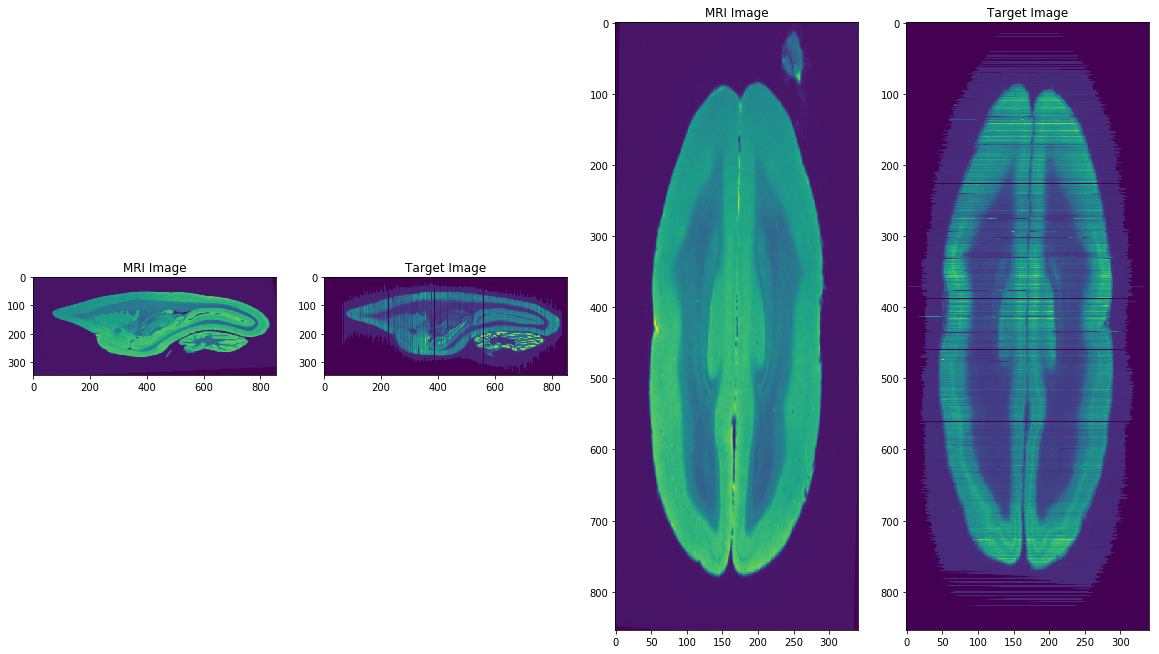

In [12]:
plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_upsampled[:,:,100])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_upsampled[96,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget[96,:,:])
plt.title('Target Image')
plt.show()

In [13]:
# write out transforms
aout = a.cpu().numpy()
bout = b.cpu().numpy()
tout = theta.cpu().numpy()
aout = np.delete(aout,missingslices)
bout = np.delete(bout,missingslices)
tout = np.delete(tout,missingslices)
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_a.txt',aout,delimiter='\n')
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_b.txt',bout,delimiter='\n')
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_theta.txt',tout,delimiter='\n')
SAR
# write out rotation center
rotcenter = [outtarget.shape[0]/2.0*0.08, outtarget.shape[2]/2.0*0.08]
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_rotcenter.txt',rotcenter,delimiter='\n')

# write out the reconstructed target image
outimg = nib.AnalyzeImage(outtarget,None)
outimg.header['pixdim'][1:4] = [0.08,0.04,0.08]marmoset
nib.save(outimg, '/cis/home/jtrieu/Documents/M519_orig_target_STS.img')

In [14]:
aout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_a.txt',delimiter='\n')
bout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_b.txt',delimiter='\n')
tout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_theta.txt',delimiter='\n')
rotcenter = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_rotcenter.txt',delimiter='\n')
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_XForm_matrix.txt','w')
for i in range(len(aout)):
    file.write(str(np.cos(tout[i])) + ',' + str(-1*np.sin(tout[i])) + ',' + str(np.sin(tout[i])) + ',' + str(np.cos(tout[i])) + ',' + str(aout[i]) + ',' + str(bout[i]) + ',' + str(rotcenter[0]) + ',' + str(rotcenter[1]) + '\n')

file.close()



## Map atlas to reconstructed target

In [15]:
# i/o
target_image = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img').get_data().astype(np.float32)
template_image = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/atlas_80_flip_masked_eroded_refined.img').get_data().astype(np.float32))
dx = [0.08,0.08,0.08]

# downsample the target
target_sitk = sitk.GetImageFromArray(np.transpose(target_image,(2,1,0)))
target_sitk.SetSpacing((0.08,0.04,0.08))
target_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(target_sitk, [target_image.shape[0],int(np.round(target_image.shape[1]/2.0)),target_image.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))

# pad the atlas and the target
templatepadsize = [max(target_ds.shape[0],template_image.shape[0]), max(int(np.round(target_image.shape[1]/2.0)),template_image.shape[1]), max(target_ds.shape[2],template_image.shape[2])]
target_padded = np.zeros(templatepadsize)
target_padded[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]] = np.copy(target_ds)
template_padded = np.zeros(templatepadsize)
template_padded[0:template_image.shape[0],0:template_image.shape[1],0:template_image.shape[2]] = np.copy(template_image)




### Do affine alignment

In [16]:
lddmm = torch_lddmm.LDDMM(template=[template_padded],target=[target_padded],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,epsilonL=4e-8,epsilonT=8e-6)
torch.cuda.empty_cache()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 4e-08 (gradient descent step size, affine)
>    epsilonT        = 8e-06 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

In [17]:
lddmm.run()

iter: 0, E = 37502.2109, ER = 0.0000, EM = 37502.2109, epd = 0.005000.
iter: 1, E= 37201.605, ER= 0.000, EM= 37201.605, epd= 0.005, time= 0.44s.
iter: 2, E= 36968.363, ER= 0.000, EM= 36968.363, epd= 0.005, time= 0.44s.
iter: 3, E= 36809.645, ER= 0.000, EM= 36809.645, epd= 0.005, time= 0.44s.
iter: 4, E= 36498.320, ER= 0.000, EM= 36498.320, epd= 0.005, time= 0.44s.
iter: 5, E= 36082.188, ER= 0.000, EM= 36082.188, epd= 0.005, time= 0.44s.
iter: 6, E= 35692.238, ER= 0.000, EM= 35692.238, epd= 0.005, time= 0.44s.
iter: 7, E= 35145.625, ER= 0.000, EM= 35145.625, epd= 0.005, time= 0.44s.
iter: 8, E= 34374.027, ER= 0.000, EM= 34374.027, epd= 0.005, time= 0.44s.
iter: 9, E= 33549.051, ER= 0.000, EM= 33549.051, epd= 0.005, time= 0.44s.
iter: 10, E= 32882.852, ER= 0.000, EM= 32882.852, epd= 0.005, time= 0.44s.
iter: 11, E= 31869.736, ER= 0.000, EM= 31869.736, epd= 0.005, time= 0.44s.
iter: 12, E= 30682.537, ER= 0.000, EM= 30682.537, epd= 0.005, time= 0.44s.
iter: 13, E= 29401.398, ER= 0.000, EM=

In [18]:
lddmm.setParams('do_affine',1)
#lddmm.setParams('epsilonL',lddmm.GDBetaAffineR*lddmm.params['epsilonL']*4) # reduce step size, here we set it to the current size
#lddmm.setParams('epsilonT',lddmm.GDBetaAffineT*lddmm.params['epsilonT']*4) # reduce step size, here we set it to the current size
lddmm.setParams('epsilonL',4e-8)
lddmm.setParams('epsilonT',8e-6)
lddmm.setParams('niter',500)
lddmm.run()

Parameter 'do_affine' changed to '1'.
Parameter 'epsilonL' changed to '4e-08'.
Parameter 'epsilonT' changed to '8e-06'.
Parameter 'niter' changed to '500'.
iter: 0, E = 22177.6348, ER = 0.0000, EM = 22177.6348, epd = 0.005000.
iter: 1, E= 22125.840, ER= 0.000, EM= 22125.840, epd= 0.005, time= 0.44s.
iter: 2, E= 22025.562, ER= 0.000, EM= 22025.562, epd= 0.005, time= 0.44s.
iter: 3, E= 21868.588, ER= 0.000, EM= 21868.588, epd= 0.005, time= 0.43s.
iter: 4, E= 21751.473, ER= 0.000, EM= 21751.473, epd= 0.005, time= 0.43s.
iter: 5, E= 21652.992, ER= 0.000, EM= 21652.992, epd= 0.005, time= 0.44s.
iter: 6, E= 21523.393, ER= 0.000, EM= 21523.393, epd= 0.005, time= 0.43s.
iter: 7, E= 21418.938, ER= 0.000, EM= 21418.938, epd= 0.005, time= 0.44s.
iter: 8, E= 21335.385, ER= 0.000, EM= 21335.385, epd= 0.005, time= 0.43s.
iter: 9, E= 21230.049, ER= 0.000, EM= 21230.049, epd= 0.005, time= 0.44s.
iter: 10, E= 21114.650, ER= 0.000, EM= 21114.650, epd= 0.005, time= 0.44s.
iter: 11, E= 21016.490, ER= 0.00

iter: 107, E= 15472.011, ER= 0.000, EM= 15472.011, epd= 0.005, time= 0.44s.
iter: 108, E= 15457.019, ER= 0.000, EM= 15457.019, epd= 0.005, time= 0.44s.
iter: 109, E= 15442.287, ER= 0.000, EM= 15442.287, epd= 0.005, time= 0.43s.
iter: 110, E= 15427.824, ER= 0.000, EM= 15427.824, epd= 0.005, time= 0.44s.
iter: 111, E= 15413.605, ER= 0.000, EM= 15413.605, epd= 0.005, time= 0.44s.
iter: 112, E= 15399.674, ER= 0.000, EM= 15399.674, epd= 0.005, time= 0.44s.
iter: 113, E= 15386.049, ER= 0.000, EM= 15386.049, epd= 0.005, time= 0.44s.
iter: 114, E= 15372.779, ER= 0.000, EM= 15372.779, epd= 0.005, time= 0.44s.
iter: 115, E= 15359.857, ER= 0.000, EM= 15359.857, epd= 0.005, time= 0.44s.
iter: 116, E= 15347.265, ER= 0.000, EM= 15347.265, epd= 0.005, time= 0.43s.
iter: 117, E= 15334.933, ER= 0.000, EM= 15334.933, epd= 0.005, time= 0.44s.
iter: 118, E= 15322.916, ER= 0.000, EM= 15322.916, epd= 0.005, time= 0.44s.
iter: 119, E= 15311.179, ER= 0.000, EM= 15311.179, epd= 0.005, time= 0.43s.
iter: 120, E

iter: 215, E= 14860.622, ER= 0.000, EM= 14860.622, epd= 0.005, time= 0.44s.
iter: 216, E= 14858.772, ER= 0.000, EM= 14858.772, epd= 0.005, time= 0.44s.
iter: 217, E= 14856.951, ER= 0.000, EM= 14856.951, epd= 0.005, time= 0.43s.
iter: 218, E= 14855.171, ER= 0.000, EM= 14855.171, epd= 0.005, time= 0.44s.
iter: 219, E= 14853.426, ER= 0.000, EM= 14853.426, epd= 0.005, time= 0.44s.
iter: 220, E= 14851.730, ER= 0.000, EM= 14851.730, epd= 0.005, time= 0.44s.
iter: 221, E= 14850.091, ER= 0.000, EM= 14850.091, epd= 0.005, time= 0.43s.
iter: 222, E= 14848.502, ER= 0.000, EM= 14848.502, epd= 0.005, time= 0.44s.
iter: 223, E= 14846.965, ER= 0.000, EM= 14846.965, epd= 0.005, time= 0.44s.
iter: 224, E= 14845.465, ER= 0.000, EM= 14845.465, epd= 0.005, time= 0.43s.
iter: 225, E= 14844.001, ER= 0.000, EM= 14844.001, epd= 0.005, time= 0.43s.
iter: 226, E= 14842.561, ER= 0.000, EM= 14842.561, epd= 0.005, time= 0.44s.
iter: 227, E= 14841.145, ER= 0.000, EM= 14841.145, epd= 0.005, time= 0.43s.
iter: 228, E

iter: 323, E= 14757.288, ER= 0.000, EM= 14757.288, epd= 0.005, time= 0.44s.
iter: 324, E= 14756.777, ER= 0.000, EM= 14756.777, epd= 0.005, time= 0.43s.
iter: 325, E= 14756.270, ER= 0.000, EM= 14756.270, epd= 0.005, time= 0.44s.
iter: 326, E= 14755.768, ER= 0.000, EM= 14755.768, epd= 0.005, time= 0.43s.
iter: 327, E= 14755.277, ER= 0.000, EM= 14755.277, epd= 0.005, time= 0.43s.
iter: 328, E= 14754.795, ER= 0.000, EM= 14754.795, epd= 0.005, time= 0.44s.
iter: 329, E= 14754.321, ER= 0.000, EM= 14754.321, epd= 0.005, time= 0.44s.
iter: 330, E= 14753.854, ER= 0.000, EM= 14753.854, epd= 0.005, time= 0.43s.
iter: 331, E= 14753.391, ER= 0.000, EM= 14753.391, epd= 0.005, time= 0.44s.
iter: 332, E= 14752.931, ER= 0.000, EM= 14752.931, epd= 0.005, time= 0.43s.
iter: 333, E= 14752.478, ER= 0.000, EM= 14752.478, epd= 0.005, time= 0.44s.
iter: 334, E= 14752.031, ER= 0.000, EM= 14752.031, epd= 0.005, time= 0.43s.
iter: 335, E= 14751.590, ER= 0.000, EM= 14751.590, epd= 0.005, time= 0.44s.
iter: 336, E

iter: 431, E= 14720.316, ER= 0.000, EM= 14720.316, epd= 0.005, time= 0.44s.
iter: 432, E= 14720.108, ER= 0.000, EM= 14720.108, epd= 0.005, time= 0.43s.
iter: 433, E= 14719.899, ER= 0.000, EM= 14719.899, epd= 0.005, time= 0.43s.
iter: 434, E= 14719.693, ER= 0.000, EM= 14719.693, epd= 0.005, time= 0.44s.
iter: 435, E= 14719.487, ER= 0.000, EM= 14719.487, epd= 0.005, time= 0.43s.
iter: 436, E= 14719.282, ER= 0.000, EM= 14719.282, epd= 0.005, time= 0.43s.
iter: 437, E= 14719.076, ER= 0.000, EM= 14719.076, epd= 0.005, time= 0.44s.
iter: 438, E= 14718.873, ER= 0.000, EM= 14718.873, epd= 0.005, time= 0.44s.
iter: 439, E= 14718.670, ER= 0.000, EM= 14718.670, epd= 0.005, time= 0.43s.
iter: 440, E= 14718.470, ER= 0.000, EM= 14718.470, epd= 0.005, time= 0.43s.
iter: 441, E= 14718.270, ER= 0.000, EM= 14718.270, epd= 0.005, time= 0.44s.
iter: 442, E= 14718.071, ER= 0.000, EM= 14718.071, epd= 0.005, time= 0.43s.
iter: 443, E= 14717.873, ER= 0.000, EM= 14717.873, epd= 0.005, time= 0.43s.
iter: 444, E

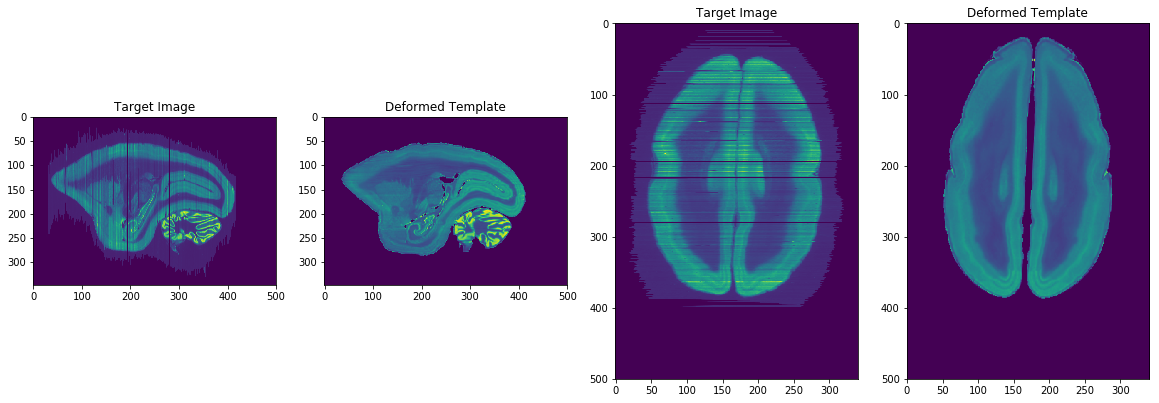

In [19]:
plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(target_padded[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,2)
plt.imshow(lddmm.It[0][-1].cpu().numpy()[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,3)
plt.imshow(target_padded[96,:,:])
plt.title('Target Image')
plt.subplot(1,4,4)
plt.imshow(lddmm.It[0][-1].cpu().numpy()[96,:,:])
plt.title('Deformed Template')
plt.show()

In [21]:
# save the affine transform
A = lddmm.affineA.cpu().numpy()
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine_transform.txt','w')
file.write(str(A[0,0]) + '\n')
file.write(str(A[0,1]) + '\n')
file.write(str(A[0,2]) + '\n')
file.write(str(A[1,0]) + '\n')
file.write(str(A[1,1]) + '\n')
file.write(str(A[1,2]) + '\n')
file.write(str(A[2,0]) + '\n')
file.write(str(A[2,1]) + '\n')
file.write(str(A[2,2]) + '\n')
file.write(str(A[3,0]) + '\n')
file.write(str(A[3,1]) + '\n')
file.write(str(A[3,2]) + '\n')
file.write(str(target_padded.shape[0]/2.0) + '\n')
file.write(str(target_padded.shape[1]/2.0) + '\n')
file.write(str(target_padded.shape[2]/2.0) + '\n')
file.close()

### crop the images back to original size

In [22]:
template_affine = lddmm.It[0][-1].cpu().numpy()[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]]
outimg = nib.AnalyzeImage(template_affine,None)
outimg.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(outimg, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine.img')

# transform the annotation
anno = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/annotation_80_flip.img').get_data().astype(np.float32))
anno_padded = np.zeros(templatepadsize)
anno_padded[0:anno.shape[0],0:anno.shape[1],0:anno.shape[2]] = np.copy(anno)

deformed_anno,_,_,_ = lddmm.applyThisTransform(anno_padded,interpmode='nearest')
deformed_anno = (deformed_anno[-1].cpu().numpy())[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]]
outimg = nib.AnalyzeImage(deformed_anno,None)
outimg.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(outimg, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_annotation_affine.img')


### do LDDMM

In [23]:
template_affine = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine.img').get_data().astype(np.float32)
# i/o
target_image = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img').get_data().astype(np.float32)
#template_image = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/atlas_80_flip_masked_eroded_refined.img').get_data().astype(np.float32))
dx = [0.08,0.08,0.08]

# downsample the target
target_sitk = sitk.GetImageFromArray(np.transpose(target_image,(2,1,0)))
target_sitk.SetSpacing((0.08,0.04,0.08))
target_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(target_sitk, [target_image.shape[0],int(np.round(target_image.shape[1]/2.0)),target_image.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))

lddmm = torch_lddmm.LDDMM(template=[template_affine],target=[target_ds],costmask=None,outdir='../notebook/',do_affine=0,do_lddmm=1,a=8,niter=250,epsilon=2e-2,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,nt=4,low_memory=1)
torch.cuda.empty_cache()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 250 (number of iterations)
>    epsilon         = 0.02 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 4 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CUD

In [24]:
lddmm.run()

iter: 0, E = 14517.8223, ER = 0.0000, EM = 14517.8223, epd = 0.020000.
iter: 1, E= 13960.471, ER= 0.031, EM= 13960.439, epd= 0.020, time= 7.53s.
iter: 2, E= 13567.852, ER= 0.119, EM= 13567.732, epd= 0.020, time= 7.50s.
iter: 3, E= 13267.103, ER= 0.255, EM= 13266.848, epd= 0.020, time= 7.52s.
iter: 4, E= 13012.331, ER= 0.432, EM= 13011.899, epd= 0.020, time= 7.52s.
iter: 5, E= 12782.595, ER= 0.644, EM= 12781.950, epd= 0.020, time= 7.52s.
iter: 6, E= 12575.961, ER= 0.885, EM= 12575.076, epd= 0.020, time= 7.52s.
iter: 7, E= 12388.028, ER= 1.149, EM= 12386.879, epd= 0.020, time= 7.53s.
iter: 8, E= 12214.601, ER= 1.432, EM= 12213.169, epd= 0.020, time= 7.50s.
iter: 9, E= 12056.410, ER= 1.729, EM= 12054.681, epd= 0.020, time= 7.52s.
iter: 10, E= 11911.374, ER= 2.037, EM= 11909.337, epd= 0.020, time= 7.51s.
iter: 11, E= 11777.410, ER= 2.354, EM= 11775.056, epd= 0.020, time= 7.51s.
iter: 12, E= 11653.511, ER= 2.679, EM= 11650.832, epd= 0.020, time= 7.50s.
iter: 13, E= 11538.729, ER= 3.009, EM=

iter: 111, E= 8866.104, ER= 31.401, EM= 8834.703, epd= 0.020, time= 7.54s.
iter: 112, E= 8858.729, ER= 31.662, EM= 8827.067, epd= 0.020, time= 7.55s.
iter: 113, E= 8851.489, ER= 31.923, EM= 8819.566, epd= 0.020, time= 7.52s.
iter: 114, E= 8844.375, ER= 32.184, EM= 8812.191, epd= 0.020, time= 7.54s.
iter: 115, E= 8837.379, ER= 32.444, EM= 8804.935, epd= 0.020, time= 7.55s.
iter: 116, E= 8830.499, ER= 32.704, EM= 8797.795, epd= 0.020, time= 7.53s.
iter: 117, E= 8823.762, ER= 32.964, EM= 8790.797, epd= 0.020, time= 7.55s.
iter: 118, E= 8817.166, ER= 33.224, EM= 8783.941, epd= 0.020, time= 7.56s.
iter: 119, E= 8810.686, ER= 33.484, EM= 8777.201, epd= 0.020, time= 7.53s.
iter: 120, E= 8804.323, ER= 33.744, EM= 8770.580, epd= 0.020, time= 7.55s.
iter: 121, E= 8798.063, ER= 34.003, EM= 8764.061, epd= 0.020, time= 7.56s.
iter: 122, E= 8791.895, ER= 34.263, EM= 8757.632, epd= 0.020, time= 7.54s.
iter: 123, E= 8785.814, ER= 34.522, EM= 8751.292, epd= 0.020, time= 7.53s.
iter: 124, E= 8779.804, E

iter: 221, E= 8437.914, ER= 59.699, EM= 8378.215, epd= 0.020, time= 7.51s.
iter: 222, E= 8435.901, ER= 59.976, EM= 8375.926, epd= 0.020, time= 7.54s.
iter: 223, E= 8433.896, ER= 60.253, EM= 8373.643, epd= 0.020, time= 7.52s.
iter: 224, E= 8431.912, ER= 60.531, EM= 8371.381, epd= 0.020, time= 7.54s.
iter: 225, E= 8429.939, ER= 60.811, EM= 8369.129, epd= 0.020, time= 7.57s.
iter: 226, E= 8427.972, ER= 61.091, EM= 8366.881, epd= 0.020, time= 7.54s.
iter: 227, E= 8426.029, ER= 61.372, EM= 8364.658, epd= 0.020, time= 7.53s.
iter: 228, E= 8424.111, ER= 61.654, EM= 8362.458, epd= 0.020, time= 7.58s.
iter: 229, E= 8422.193, ER= 61.937, EM= 8360.257, epd= 0.020, time= 7.53s.
iter: 230, E= 8420.293, ER= 62.221, EM= 8358.071, epd= 0.020, time= 7.53s.
iter: 231, E= 8418.413, ER= 62.507, EM= 8355.906, epd= 0.020, time= 7.55s.
iter: 232, E= 8416.563, ER= 62.794, EM= 8353.770, epd= 0.020, time= 7.53s.
iter: 233, E= 8414.758, ER= 63.082, EM= 8351.676, epd= 0.020, time= 7.54s.
iter: 234, E= 8412.965, E

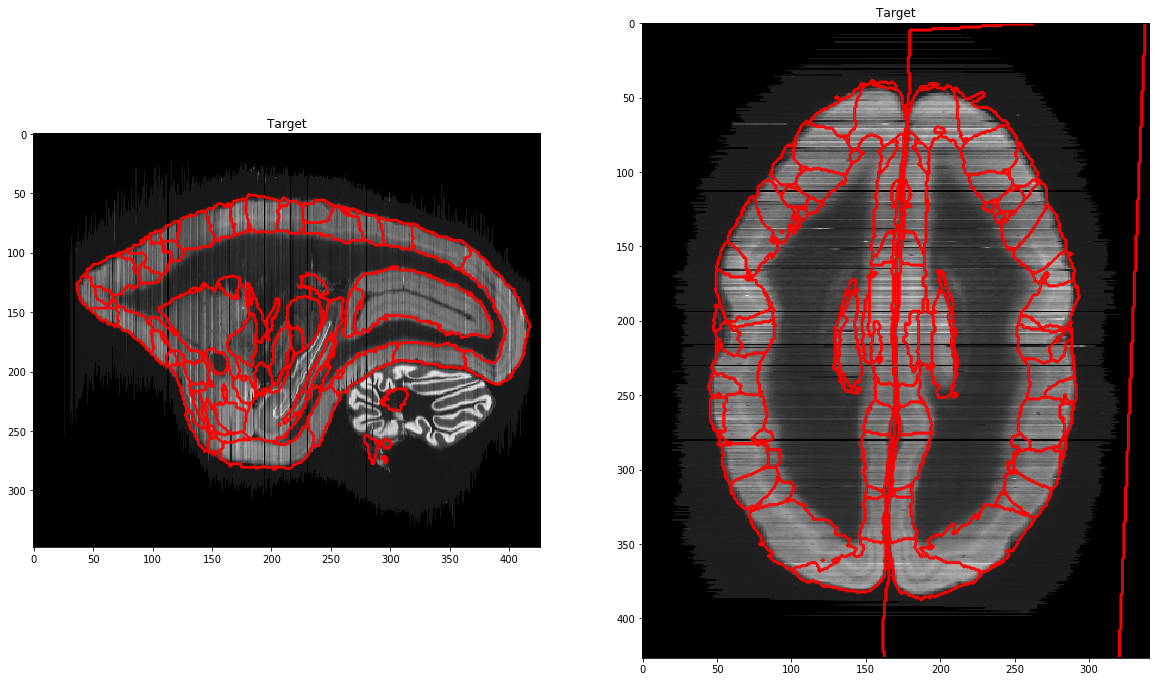

In [25]:
# transform annotation based on current transform
anno_affine = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_annotation_affine.img').get_data().astype(np.float32)
deformed_anno,_,_,_ = lddmm.applyThisTransform(anno_affine,interpmode='nearest')
deformed_anno = deformed_anno[-1].cpu().numpy()

# draw deformed annotation on target
levels = np.unique(deformed_anno[:,:,100])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(target_ds[:,:,100],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((deformed_anno[:,:,100]==levels[i])*1.0,0.999,colors='r')

levels = np.unique(deformed_anno[96,:,:])
plt.subplot(1,2,2)
plt.imshow(target_ds[96,:,:],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((deformed_anno[96,:,:]==levels[i])*1.0,0.999,colors='r')

plt.show()

In [26]:
anno_sitk = sitk.GetImageFromArray(np.transpose(deformed_anno,(2,1,0)))
anno_sitk.SetSpacing((0.08,0.08,0.08))
anno_us = sitk.Resample(anno_sitk,orignisslsize,sitk.AffineTransform(3),sitk.sitkNearestNeighbor,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
anno_us = np.transpose(sitk.GetArrayFromImage(anno_us),(2,1,0))
anno_out = nib.AnalyzeImage(anno_us,None)
anno_out.header['pixdim'][1:4] = [0.08,0.04,0.08]
nib.save(anno_out,'/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_annotation.img')

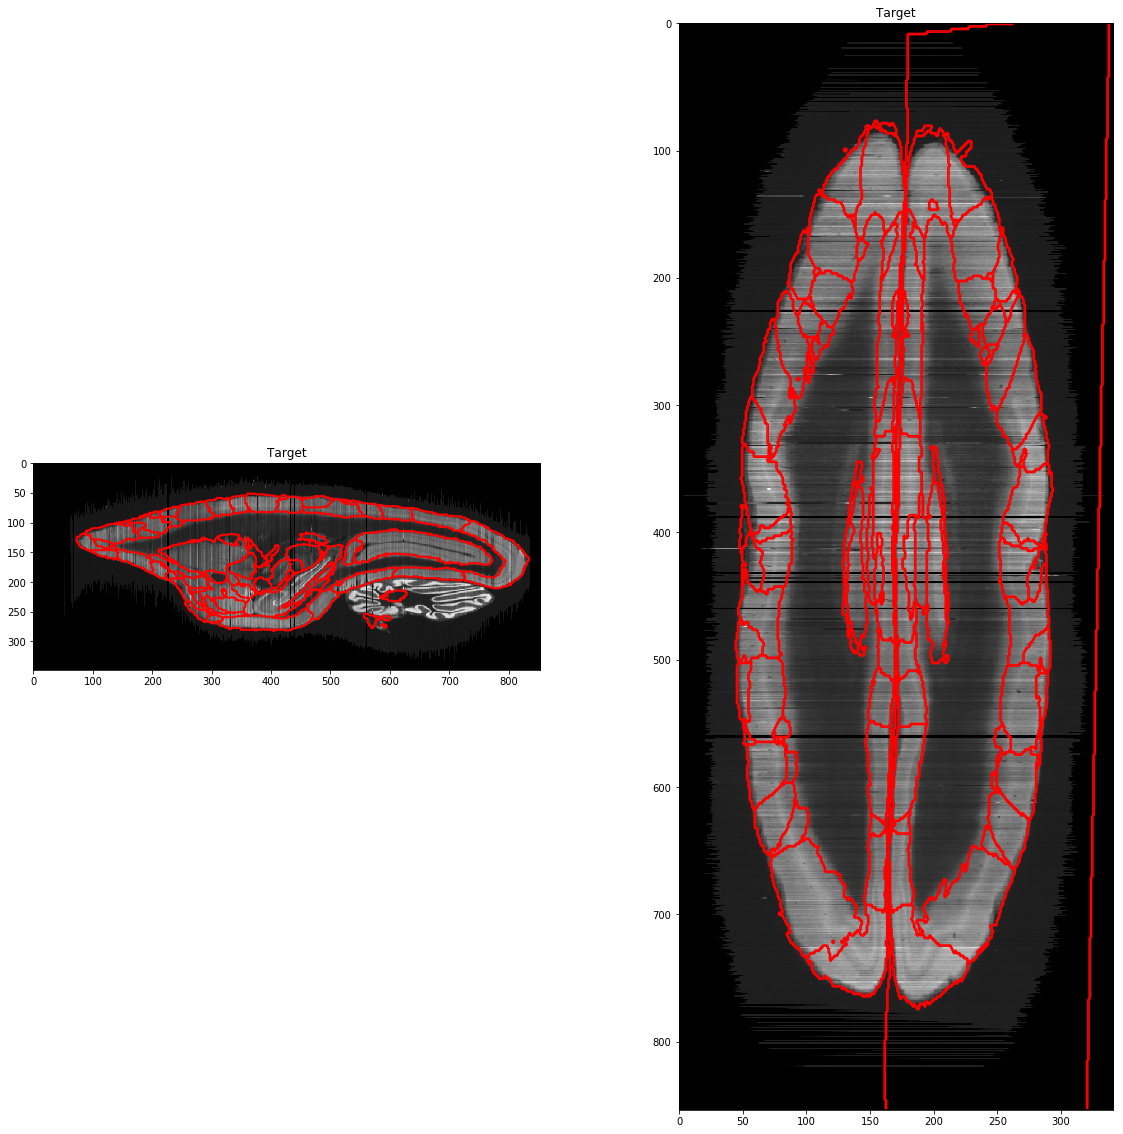

In [27]:
levels = np.unique(anno_us[:,:,100])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(target_image[:,:,100],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((anno_us[:,:,100]==levels[i])*1.0,0.999,colors='r')

levels = np.unique(anno_us[96,:,:])
plt.subplot(1,2,2)
plt.imshow(target_image[96,:,:],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((anno_us[96,:,:]==levels[i])*1.0,0.999,colors='r')

plt.show()

In [28]:
# save transforms
vt0,vt1,vt2 = lddmm.outputTransforms()
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt0.npy',vt0)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt1.npy',vt1)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt2.npy',vt2)

## Warp MRI to reconstructed target

In [2]:
target_file_name = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img'
mri_file_name = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_mri_full.img'

target_image = nib.load(target_file_name).get_data().astype(np.float32)
mri_image = nib.load(mri_file_name).get_data().astype(np.float32)

mripadsize = [max(target_image.shape[0],int(np.round(mri_image.shape[0]*0.06/0.08))), max(int(np.round(target_image.shape[1]/2.0)),int(np.round(mri_image.shape[1]*0.06/0.08))), max(target_image.shape[2],int(np.round(mri_image.shape[2]*0.06/0.08)))]

target_sitk = sitk.ReadImage(target_file_name)
target_sitk_resample = sitk.Resample(target_sitk,mripadsize,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(target_sitk_resample.GetSize())
target_resample = np.transpose(sitk.GetArrayFromImage(target_sitk_resample),(2,1,0))
print(target_resample.shape)

mri_sitk = sitk.ReadImage(mri_file_name)
print(mri_sitk.GetSize())
mri_sitk_resample = sitk.Resample(mri_sitk,target_resample.shape,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(mri_sitk_resample.GetSize())
mri_resample = np.transpose(sitk.GetArrayFromImage(mri_sitk_resample),(2,1,0))
print(mri_resample.shape)

#target_padded = np.zeros(mripadsize)
#target_padded[0:target_image.shape[0],0:target_image.shape[1],0:target_image.shape[2]] = np.copy(target_image)
#mri_padded = np.zeros(mripadsize)
#mri_padded[0:mri_image.shape[0],0:mri_image.shape[1],0:mri_image.shape[2]] = np.copy(mri_image)

(348, 450, 345)
(348, 450, 345)
(460, 600, 460)
(348, 450, 345)
(348, 450, 345)


In [3]:
dx=[0.08,0.08,0.08]
lddmm = torch_lddmm.LDDMM(template=[mri_resample],target=[target_resample],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1)
lddmm.run()



Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CU

In [4]:
lddmm.setParams('do_affine',1)
lddmm.run()

Parameter 'do_affine' changed to '1'.
iter: 0, E = 15630.7969, ER = 0.0000, EM = 15630.7969, epd = 0.005000.
iter: 1, E= 15490.696, ER= 0.000, EM= 15490.696, epd= 0.005, time= 0.40s.
iter: 2, E= 15368.836, ER= 0.000, EM= 15368.836, epd= 0.005, time= 0.40s.
iter: 3, E= 15258.897, ER= 0.000, EM= 15258.897, epd= 0.005, time= 0.40s.
iter: 4, E= 15158.605, ER= 0.000, EM= 15158.605, epd= 0.005, time= 0.40s.
iter: 5, E= 15064.715, ER= 0.000, EM= 15064.715, epd= 0.005, time= 0.40s.
iter: 6, E= 14977.628, ER= 0.000, EM= 14977.628, epd= 0.005, time= 0.40s.
iter: 7, E= 14897.344, ER= 0.000, EM= 14897.344, epd= 0.005, time= 0.40s.
iter: 8, E= 14822.230, ER= 0.000, EM= 14822.230, epd= 0.005, time= 0.40s.
iter: 9, E= 14752.100, ER= 0.000, EM= 14752.100, epd= 0.005, time= 0.40s.
iter: 10, E= 14685.439, ER= 0.000, EM= 14685.439, epd= 0.005, time= 0.40s.
iter: 11, E= 14622.680, ER= 0.000, EM= 14622.680, epd= 0.005, time= 0.40s.
iter: 12, E= 14564.270, ER= 0.000, EM= 14564.270, epd= 0.005, time= 0.40s.


iter: 108, E= 12469.692, ER= 0.000, EM= 12469.692, epd= 0.005, time= 0.40s.
iter: 109, E= 12458.677, ER= 0.000, EM= 12458.677, epd= 0.005, time= 0.40s.
iter: 110, E= 12447.794, ER= 0.000, EM= 12447.794, epd= 0.005, time= 0.40s.
iter: 111, E= 12437.062, ER= 0.000, EM= 12437.062, epd= 0.005, time= 0.40s.
iter: 112, E= 12426.478, ER= 0.000, EM= 12426.478, epd= 0.005, time= 0.40s.
iter: 113, E= 12416.058, ER= 0.000, EM= 12416.058, epd= 0.005, time= 0.40s.
iter: 114, E= 12405.805, ER= 0.000, EM= 12405.805, epd= 0.005, time= 0.40s.
iter: 115, E= 12395.711, ER= 0.000, EM= 12395.711, epd= 0.005, time= 0.40s.
iter: 116, E= 12385.765, ER= 0.000, EM= 12385.765, epd= 0.005, time= 0.40s.
iter: 117, E= 12375.957, ER= 0.000, EM= 12375.957, epd= 0.005, time= 0.40s.
iter: 118, E= 12366.282, ER= 0.000, EM= 12366.282, epd= 0.005, time= 0.40s.
iter: 119, E= 12356.736, ER= 0.000, EM= 12356.736, epd= 0.005, time= 0.40s.
iter: 120, E= 12347.314, ER= 0.000, EM= 12347.314, epd= 0.005, time= 0.40s.
iter: 121, E

In [5]:
# save transforms
# save the affine transform
A = lddmm.affineA.cpu().numpy()
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_affine_transform.txt','w')
file.write(str(A[0,0]) + '\n')
file.write(str(A[0,1]) + '\n')
file.write(str(A[0,2]) + '\n')
file.write(str(A[1,0]) + '\n')
file.write(str(A[1,1]) + '\n')
file.write(str(A[1,2]) + '\n')
file.write(str(A[2,0]) + '\n')
file.write(str(A[2,1]) + '\n')
file.write(str(A[2,2]) + '\n')
file.write(str(A[3,0]) + '\n')
file.write(str(A[3,1]) + '\n')
file.write(str(A[3,2]) + '\n')
file.write(str(target_resample.shape[0]/2.0) + '\n')
file.write(str(target_resample.shape[1]/2.0) + '\n')
file.write(str(target_resample.shape[2]/2.0) + '\n')
file.close()

In [6]:
# crop the MRI back to original target size

target_sitk = sitk.ReadImage(target_file_name)
target_sitk_resample = sitk.Resample(target_sitk,[target_sitk.GetSize()[0],int(np.round(target_sitk.GetSize()[1]/2.0)),target_sitk.GetSize()[2]],sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(target_sitk_resample.GetSize())
target_resample = np.transpose(sitk.GetArrayFromImage(target_sitk_resample),(2,1,0))
print(target_resample.shape)

mri_affine = lddmm.It[0][-1].cpu().numpy()
mri_affine = mri_affine[0:target_resample.shape[0], 0:target_resample.shape[1],0:target_resample.shape[2]]

(348, 427, 341)
(348, 427, 341)


In [7]:
lddmm = torch_lddmm.LDDMM(template=[mri_affine],target=[target_resample],costmask=None,outdir='../notebook/',do_affine=0,do_lddmm=1,a=8,niter=250,epsilon=2e-2,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,nt=4,low_memory=1)
torch.cuda.empty_cache()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 250 (number of iterations)
>    epsilon         = 0.02 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 4 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (index of CUD

In [8]:
lddmm.run()

iter: 0, E = 12095.8721, ER = 0.0000, EM = 12095.8721, epd = 0.020000.
iter: 1, E= 11744.982, ER= 0.026, EM= 11744.956, epd= 0.020, time= 7.68s.
iter: 2, E= 11473.364, ER= 0.099, EM= 11473.266, epd= 0.020, time= 7.70s.
iter: 3, E= 11255.185, ER= 0.209, EM= 11254.976, epd= 0.020, time= 7.56s.
iter: 4, E= 11061.971, ER= 0.351, EM= 11061.620, epd= 0.020, time= 7.57s.
iter: 5, E= 10889.516, ER= 0.519, EM= 10888.996, epd= 0.020, time= 7.59s.
iter: 6, E= 10734.914, ER= 0.709, EM= 10734.205, epd= 0.020, time= 7.73s.
iter: 7, E= 10594.210, ER= 0.914, EM= 10593.296, epd= 0.020, time= 7.56s.
iter: 8, E= 10466.719, ER= 1.132, EM= 10465.587, epd= 0.020, time= 7.61s.
iter: 9, E= 10352.422, ER= 1.358, EM= 10351.063, epd= 0.020, time= 7.66s.
iter: 10, E= 10249.521, ER= 1.590, EM= 10247.932, epd= 0.020, time= 7.59s.
iter: 11, E= 10156.311, ER= 1.824, EM= 10154.486, epd= 0.020, time= 7.68s.
iter: 12, E= 10072.581, ER= 2.059, EM= 10070.521, epd= 0.020, time= 7.64s.
iter: 13, E= 9997.715, ER= 2.293, EM= 

iter: 112, E= 8629.681, ER= 16.669, EM= 8613.012, epd= 0.020, time= 7.60s.
iter: 113, E= 8626.371, ER= 16.773, EM= 8609.598, epd= 0.020, time= 7.71s.
iter: 114, E= 8623.096, ER= 16.878, EM= 8606.218, epd= 0.020, time= 7.72s.
iter: 115, E= 8619.863, ER= 16.982, EM= 8602.881, epd= 0.020, time= 7.67s.
iter: 116, E= 8616.668, ER= 17.086, EM= 8599.582, epd= 0.020, time= 7.73s.
iter: 117, E= 8613.508, ER= 17.190, EM= 8596.318, epd= 0.020, time= 7.62s.
iter: 118, E= 8610.380, ER= 17.293, EM= 8593.087, epd= 0.020, time= 7.72s.
iter: 119, E= 8607.287, ER= 17.397, EM= 8589.891, epd= 0.020, time= 7.86s.
iter: 120, E= 8604.229, ER= 17.500, EM= 8586.729, epd= 0.020, time= 7.63s.
iter: 121, E= 8601.208, ER= 17.603, EM= 8583.604, epd= 0.020, time= 7.69s.
iter: 122, E= 8598.217, ER= 17.706, EM= 8580.511, epd= 0.020, time= 7.64s.
iter: 123, E= 8595.257, ER= 17.809, EM= 8577.448, epd= 0.020, time= 7.64s.
iter: 124, E= 8592.326, ER= 17.912, EM= 8574.415, epd= 0.020, time= 7.63s.
iter: 125, E= 8589.425, E

iter: 222, E= 8392.977, ER= 27.752, EM= 8365.225, epd= 0.020, time= 7.79s.
iter: 223, E= 8391.516, ER= 27.853, EM= 8363.663, epd= 0.020, time= 7.78s.
iter: 224, E= 8390.067, ER= 27.954, EM= 8362.113, epd= 0.020, time= 7.64s.
iter: 225, E= 8388.626, ER= 28.055, EM= 8360.571, epd= 0.020, time= 7.55s.
iter: 226, E= 8387.191, ER= 28.156, EM= 8359.035, epd= 0.020, time= 7.71s.
iter: 227, E= 8385.763, ER= 28.257, EM= 8357.506, epd= 0.020, time= 7.54s.
iter: 228, E= 8384.341, ER= 28.358, EM= 8355.982, epd= 0.020, time= 7.60s.
iter: 229, E= 8382.927, ER= 28.459, EM= 8354.467, epd= 0.020, time= 7.58s.
iter: 230, E= 8381.518, ER= 28.561, EM= 8352.957, epd= 0.020, time= 7.62s.
iter: 231, E= 8380.117, ER= 28.662, EM= 8351.455, epd= 0.020, time= 7.59s.
iter: 232, E= 8378.724, ER= 28.764, EM= 8349.960, epd= 0.020, time= 7.65s.
iter: 233, E= 8377.335, ER= 28.865, EM= 8348.470, epd= 0.020, time= 7.70s.
iter: 234, E= 8375.955, ER= 28.967, EM= 8346.988, epd= 0.020, time= 7.80s.
iter: 235, E= 8374.580, E

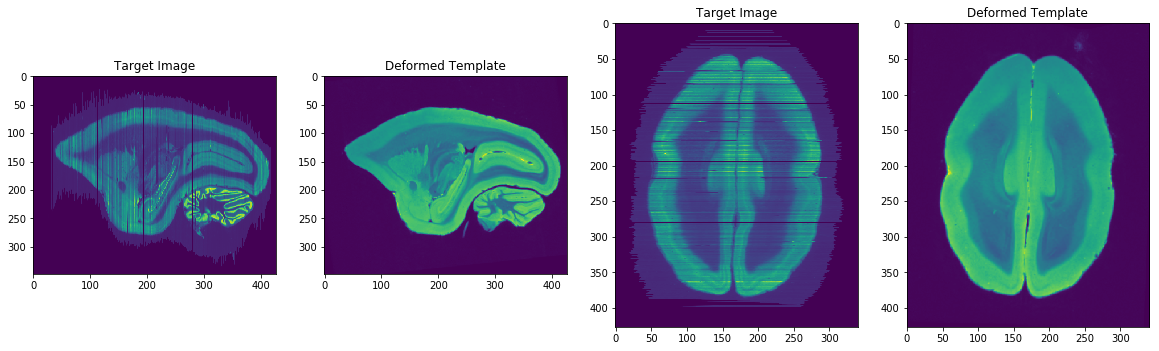

In [14]:
deformed_mri,_,_,_ = lddmm.applyThisTransform(mri_affine,interpmode='bilinear')
deformed_mri = deformed_mri[-1].cpu().numpy()

plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(target_resample[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,2)
plt.imshow(deformed_mri[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,3)
plt.imshow(target_resample[96,:,:])
plt.title('Target Image')
plt.subplot(1,4,4)
plt.imshow(deformed_mri[96,:,:])
plt.title('Deformed Template')
plt.show()

out_mri = nib.AnalyzeImage(deformed_mri, None)
out_mri.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(out_mri, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_lddmm.img')

In [15]:


# save transforms
vt0,vt1,vt2 = lddmm.outputTransforms()
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt0.npy',vt0)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt1.npy',vt1)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt2.npy',vt2)